### running the evaluation for the chal dataset

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from torchinfo import summary
from collections import defaultdict, namedtuple
import pandas as pd
# import proplot as pplt
import warnings
warnings.filterwarnings("ignore") # I should only put this in place when I am doing plotting and using proplot....
from twaibrain.braintorch.utils.resize import crop_or_pad_dims
from twaibrain.brainpreprep.utils.image_io import load_image
import scipy
import scipy.stats

# model architecture
import json
from twaibrain.braintorch.models.nnUNet.nnUNetV2_model_loader import get_network_from_plans
from twaibrain.braintorch.models.ssn import SSN_Wrapped_Deep_Supervision, SSN_Wrapped_Deep_Supervision_LLO, Hierarchical_SSN_with_ConvRefine, Hierarchical_SSN_with_ConvSpatialAttention

# fitting code
from twaibrain.braintorch.fitting_and_inference.get_trainer import get_trainer
from twaibrain.braintorch.fitting_and_inference.get_scratch_dir import scratch_dir
from twaibrain.braintorch.fitting_and_inference.optimizer_constructor import OptimizerConfigurator
from twaibrain.braintorch.fitting_and_inference.lightning_fitter import StandardLitModelWrapper

# loss function
from twaibrain.braintorch.losses.ssn_losses import DeepSupervisionSSN, SSNCombinedDiceXent_and_MC_loss, SSNCombinedDiceXent_and_MC_loss_FromSamples
from twaibrain.braintorch.losses.generic_deep_supervision import MultiDeepSupervisionLoss, DeepSupervisionLoss
from twaibrain.braintorch.losses.dice_loss import SoftDiceV2
from twaibrain.braintorch.losses.xent import dice_xent_loss

# data
from twaibrain.brainexperiments.run_nnUNet_v2.old_dataloading.dataset_pipelines import load_data
from twaibrain.braintorch.data.legacy_dataset_types.dataset_wrappers import MonaiAugmentedDataset
from twaibrain.braintorch.augmentation.nnunet_augmentations import get_nnunet_transforms, get_val_transforms
from torch.utils.data import ConcatDataset
from twaibrain.braintorch.data.legacy_dataset_types.mri_dataset_inram import MRISegmentation3DDataset
from twaibrain.braintorch.data.legacy_dataset_types.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaibrain.braintorch.data.legacy_dataset_types.mri_dataset_directory_parsers import *

# evaluation code
from twaibrain.brainexperiments.run_nnUNet_v2.evaluation.eval_helper_functions import *
from twaibrain.brainexperiments.run_nnUNet_v2.evaluation.model_predictions import get_means_and_samples_2D, ssn_ensemble_mean_and_samples
from twaibrain.brainexperiments.run_nnUNet_v2.evaluation.model_predictions import *

### setting up params for the rest of the code to run

In [4]:
ARGS = namedtuple("args", "dataset test_split val_split seed " + 
                  "empty_slice_retention batch_size cross_validate cv_split cv_test_fold_smooth no_test_fold " +
                  "num_workers dice_factor xent_factor xent_reweighting eval_split uncertainty_type ckpt_dir"
)

In [5]:
VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140
ESR = 0.5


# setup xent reweighting factor
XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-ESR) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2

In [6]:
args = ARGS(
    dataset = "chal",
    
    test_split=0.15,
    val_split=0.15,
    eval_split='all',

    seed=5,

    empty_slice_retention=ESR,

    uncertainty_type="ssn",

    batch_size=2,
    cross_validate=True,
    cv_split=0,
    cv_test_fold_smooth=1,
    no_test_fold="false",
    num_workers=16,

    dice_factor=1,
    xent_factor=1,
    xent_reweighting=XENT_WEIGHTING,
    ckpt_dir= "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/"
)

### loading eval data

In [6]:
data_dict = load_data(
    dataset=args.dataset, 
    test_proportion=args.test_split, 
    validation_proportion=args.val_split,
    seed=args.seed,
    empty_proportion_retained=args.empty_slice_retention,
    batch_size=args.batch_size,
    dataloader2d_only=False,
    cross_validate=args.cross_validate,
    cv_split=args.cv_split,
    cv_test_fold_smooth=args.cv_test_fold_smooth,
    merge_val_test=args.no_test_fold
)

NameError: name 'args' is not defined

In [8]:
if args.eval_split == "all":
    eval_ds = ConcatDataset([data_dict['train_dataset3d'], data_dict['val_dataset3d'], data_dict['test_dataset3d']])
else:
    eval_ds = data_dict[f'{args.eval_split}_dataset3d']

In [9]:
len(eval_ds)

60

In [10]:
# get the xs and ys
xs3d_test = []
ys3d_test = []

for i, data in enumerate(eval_ds):
    ys3d_test.append(data[1].squeeze())
    xs3d_test.append(data[0])

In [11]:
ys3d_test = [y * (y==1).type(y.dtype) for y in ys3d_test] # fix bug with challenge data having 3 classes on cluster only?
gt_vols = GT_volumes(ys3d_test)

In [12]:
# to run on the nnUnet version of the model,
# I should crop the x and y to the min and max points
# this will also effectively centre the images for evaluation.
for i in range(len(xs3d_test)):
    x = xs3d_test[i]
    y = ys3d_test[i]
    wheres = torch.where(x[-1])
    zs = (wheres[0].min().item(), wheres[0].max().item())
    xs = (wheres[1].min().item(), wheres[1].max().item())
    ys = (wheres[2].min().item(), wheres[2].max().item())
    # print(zs, xs, ys)
    # print(x.shape, y.shape)

    x = x[:, zs[0]:zs[1]+1, xs[0]:xs[1]+1, ys[0]:ys[1]+1]
    y = y[zs[0]:zs[1]+1, xs[0]:xs[1]+1, ys[0]:ys[1]+1]

    # print(x.shape, y.shape)
    
    x = crop_or_pad_dims(x, [1,2,3], [48, 192, 192])
    y = crop_or_pad_dims(y, [0,1,2], [48, 192, 192])

    x = x.unsqueeze(0)

    # print(x.shape, y.shape)
    # print()
    xs3d_test[i] = x
    ys3d_test[i] = y

(-0.5, 191.5, -0.5, 191.5)

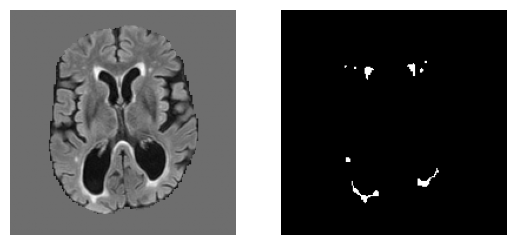

In [13]:
plt.subplot(1,2,1)
plt.imshow(xs3d_test[30][0][0][24], cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ys3d_test[30][24], cmap='gray', origin='lower')
plt.axis('off')

### load a model checkpoint and get relevant predictions

In [14]:
model_config = "/home/s2208943/projects/twaibrain/twaibrain/braintorch/models/nnUNet/cvd_configs/nnUNetResEncUNetMPlans.json"

with open(model_config) as f:
    model_config = json.load(f)

In [15]:
dims = "2d"
config = model_config['configurations'][dims]['architecture']
network_name = config['network_class_name']
kw_requires_import = config['_kw_requires_import']

def get_model():
    return get_network_from_plans(
        arch_class_name=network_name,
        arch_kwargs=config['arch_kwargs'],
        arch_kwargs_req_import=kw_requires_import,
        input_channels=3,
        output_channels=32,
        allow_init=True,
        deep_supervision=True,
    )

model = get_model()

In [16]:
ssn_config = {
    'intermediate_channels':32,
    'out_channels':2,
    'dims':2,
    'rank':25,
    'diagonal':False,
}

ssn_model = SSN_Wrapped_Deep_Supervision(model, 5, ssn_config)

In [17]:
ensemble_models = [ssn_model] + [SSN_Wrapped_Deep_Supervision(get_model(), 5, ssn_config) for _ in range(9)]

In [18]:
# %autoreload

In [1]:
def get_model_preds(cv_fold, model=model, model_name="nnunet", ckpt_path=None, model_func=deterministic_mean, do_reorder_samples=False, load_ckpt=True, out_domain=True):
    if load_ckpt:
        model = load_best_checkpoint(model, None, '.', cv_fold, ckpt_path).model
    
    means, samples, miscs = get_means_and_samples_2D(model, zip(xs3d_test, ys3d_test), 10, model_func, args=args)

    print(means[0].shape, samples[0].shape, ys3d_test[0].shape)

    means = [m.squeeze(0).swapaxes(0, 1) for m in means]
    means = [m[:,:2] for m in means]
    if samples[0] is not None:
        samples = [s.swapaxes(2, 3) for s in samples]
        samples = [s[:,:,:,:2].squeeze() for s in samples]
        

    print(means[0].shape, samples[0].shape)

    chal_results = per_model_chal_stats(means, ys3d_test)

    rmses = []
    for m, y in zip(means, ys3d_test):
        m = m.cuda()
        m = m.softmax(dim=1)[:,:2]
        rmses.append(fast_rmse(m, y.cuda()).cpu())
    rmses = torch.Tensor(rmses)
    chal_results['rmse'] = rmses

    chal_results['gt_vols'] = gt_vols

    # run the evaluation on the samples
    print("GETTING PER SAMPLE RESULTS")
    if samples[0] is not None:
        if do_reorder_samples:
            samples = [reorder_samples(s) for s in samples]
        sample_top_dices, sample_dices = per_sample_metric(samples, ys3d_test, f=fast_dice, do_argmax=True, do_softmax=False, minimise=False)
        sample_best_avds, sample_avds = per_sample_metric(samples, ys3d_test, f=fast_avd, do_argmax=True, do_softmax=False, minimise=True)
        sample_best_rmses, sample_rmses = per_sample_metric(samples, ys3d_test, f=fast_rmse, do_argmax=False, do_softmax=True, minimise=True)
    
        # best dice, avd, rmse
        chal_results['best_dice'] = sample_top_dices
        chal_results['best_avd'] = sample_best_avds
        chal_results['best_rmse'] = sample_best_rmses
        
        _, sample_vds = per_sample_metric(samples, ys3d_test, f=fast_vd, do_argmax=True, do_softmax=False, minimise=True, take_abs=False)
        sample_vd_skew = torch.from_numpy(scipy.stats.skew(sample_vds, axis=1, bias=True))
    
        # vd of the sample distribution
        chal_results['sample_vd_skew'] = sample_vd_skew
        for s in range(sample_vds.shape[1]):
            chal_results[f'sample_{s}_vd'] = sample_vds[:,s]
            
        # ged score
        geds = iou_GED(means, ys3d_test, samples)
        chal_results['GED^2'] = geds

    # get the uncertainty maps
    print("GENREATING UNCERTAINTY MAPS")
    uncertainty_thresholds = torch.arange(0, 0.7, 0.01)
    ent_maps = get_uncertainty_maps(means, samples, miscs, args)

    # pavpu
    print("PAVPU")
    all_acc_cert, all_uncert_inacc,all_pavpu = all_individuals_pavpu(means, ent_maps, ys3d_test, 4, 0.8, uncertainty_thresholds)
    
    for i, tau in enumerate(uncertainty_thresholds):
        chal_results[f'p_acc_cert_{tau:.2f}'] = all_acc_cert[:,i]
        chal_results[f'p_uncert_inacc_{tau:.2f}'] = all_uncert_inacc[:,i]
        chal_results[f'pavpu_{tau:.2f}'] = all_pavpu[:,i]
    
    # sUEO score and UEO per threshold
    print("UEO")
    sUEOs = get_sUEOs(means, ys3d_test, ent_maps)
    chal_results['sUEO'] = sUEOs
    ueos = UEO_per_threshold_analysis(uncertainty_thresholds, ys3d_test, ent_maps, means, 0.7)
    for i, tau in enumerate(uncertainty_thresholds):
        chal_results[f'UEO_{tau:.2f}'] = ueos[i]
    
    # 3D connected component analysis
    print("3D CC ANALYSIS")
    num_lesions_all, sizes_all, mean_missed_area3d_all, mean_size_missed_lesions3d_all, mean_cov_mean_missed_lesions3d_all, prop_lesions_missed3d_all = do_3d_cc_analysis_per_individual(means, ys3d_test, ent_maps, uncertainty_thresholds)
    for i, tau in enumerate(uncertainty_thresholds):
        chal_results[f'mean_missed_area3d_all_{tau:.2f}'] = torch.stack(mean_missed_area3d_all)[:,i]
        chal_results[f'mean_cov_mean_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_cov_mean_missed_lesions3d_all)[:,i]
        chal_results[f'mean_size_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_size_missed_lesions3d_all)[:,i]
        chal_results[f'prop_lesions_missed3d_all_{tau:.2f}'] = torch.stack(prop_lesions_missed3d_all)[:,i]
        

    # save the results
    print("SAVING RESULTS")
    domain_folder = "out_domain_results" if out_domain else "in_domain_results"
    results_out_dir = f"/home/s2208943/ipdis/WMH_UQ_assessment/trustworthai/journal_run/evaluation/results/cross_validated_results/{domain_folder}/"
    write_per_model_channel_stats(results_out_dir, model_name, f"{model_name}0_cv{cv_fold}", preds=None, ys3d_test=None, args=args, chal_results=chal_results)
    
    print("DONE")

NameError: name 'model' is not defined

### X2 SSN Ens full challenge

In [20]:
base_folder = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/"

for cv_split in range(6):
    loaded_ensemble_models = []
    for m in range(10):
        model_dir = os.path.join(base_folder, f"nnunet2D_ssnX2_ens{m}_cv{cv_split}")  
        print("model dir: ", model_dir)
        ckpt = sorted([f for f in os.listdir(model_dir) if f.endswith(".ckpt")])[-1]
        
        loaded_ensemble_models.append(load_best_checkpoint(ensemble_models[m], None, None, None, os.path.join(model_dir, ckpt)).model.cuda())
    
    get_model_preds(cv_split, model=loaded_ensemble_models, model_name="SsnEnsNnunet2DX2", ckpt_path=None, model_func=ssn_ensemble_mean_and_samples, load_ckpt=False)

model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens0_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens1_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens2_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens3_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens4_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens5_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens6_cv0
model dir:  /

60it [02:02,  2.04s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:06<00:00,  1.10s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.78it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  7.48it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.78it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.37it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:55<00:00,  1.93s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens0_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens1_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens2_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens3_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens4_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens5_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_en

60it [02:00,  2.00s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.04s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.78it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.70it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.44it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.41it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:59<00:00,  1.98s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens0_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens1_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens2_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens3_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens4_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens5_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_en

60it [01:59,  1.99s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:00<00:00,  1.01s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.80it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.89it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.06it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.40it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:57<00:00,  1.96s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens0_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens1_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens2_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens3_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens4_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens5_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_en

60it [01:59,  2.00s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:00<00:00,  1.01s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.80it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.68it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.41it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.45it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:55<00:00,  1.92s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens0_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens1_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens2_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens3_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens4_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens5_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_en

60it [01:59,  2.00s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:01<00:00,  1.02s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.79it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.81it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.23it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.37it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:52<00:00,  1.88s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens0_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens1_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens2_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens3_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens4_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_ens5_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/nnunet2D_ssnX2_en

60it [01:59,  1.98s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [00:58<00:00,  1.03it/s]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.84it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.04it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.36it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.35it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:55<00:00,  1.93s/it]


SAVING RESULTS
DONE


### SSN Xv Challenge

In [23]:
base_folder = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts_redo/"
for folder in [f for f in os.listdir(base_folder) if "ens0" in f]:
    if "3D" in folder:
        continue
    if "ssnX" not in folder:
        continue
    print(folder)
    cv_split = folder[-1]
    v = folder.split("ssnX")[1][0]
    ckpt = sorted([f for f in os.listdir(os.path.join(base_folder, folder)) if f.endswith(".ckpt")])[-1]
    get_model_preds(cv_split, model=ssn_model, model_name=f"SsnX{v}Nnunet2D", ckpt_path=os.path.join(base_folder, folder, ckpt), model_func=ssn_mean_and_samples)

nnunet2D_ssnX0_ens0_cv4


60it [00:26,  2.22it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.82it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.58it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.79it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.48it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.94s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX2_ens0_cv5


60it [00:22,  2.61it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.79it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.08it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.15it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.46it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:57<00:00,  1.97s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX2_ens0_cv2


60it [00:21,  2.74it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.04s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.72it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.72it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.50it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:59<00:00,  1.99s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX1_ens0_cv0


60it [00:23,  2.60it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.87it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.11it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.23it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.45it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:54<00:00,  1.91s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX0_ens0_cv3


60it [00:22,  2.62it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.56it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.87it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.94s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX1_ens0_cv4


60it [00:23,  2.58it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.91it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.16it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.48it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:54<00:00,  1.90s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX1_ens0_cv3


60it [00:23,  2.59it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.81it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.55it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.15it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.42it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:55<00:00,  1.93s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX2_ens0_cv1


60it [00:22,  2.69it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.57it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.73it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.14it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.94s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX0_ens0_cv0


60it [00:22,  2.69it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.06s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.59it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.30it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.19it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.50it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.88s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX0_ens0_cv2


60it [00:22,  2.71it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.60it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.24it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.82it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:54<00:00,  1.91s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX2_ens0_cv3


60it [00:22,  2.70it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.06s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.61it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.00it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.90it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.93s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX1_ens0_cv1


60it [00:22,  2.69it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.70it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.75it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.87it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:58<00:00,  1.98s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX2_ens0_cv4


60it [00:23,  2.59it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.06s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.75it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.96it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.38it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.47it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:51<00:00,  1.85s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX0_ens0_cv5


60it [00:23,  2.59it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.76it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.01it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.63it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.43it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:57<00:00,  1.95s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX0_ens0_cv1


60it [00:23,  2.58it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.06s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.78it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.16it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.32it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:56<00:00,  1.94s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX1_ens0_cv2


60it [00:23,  2.59it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.80it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.23it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.04it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.45it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [02:01<00:00,  2.02s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX2_ens0_cv0


60it [00:22,  2.63it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:02<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.78it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.55it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.40it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [01:53<00:00,  1.90s/it]


SAVING RESULTS
DONE
nnunet2D_ssnX1_ens0_cv5


60it [00:22,  2.64it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:03<00:00,  1.05s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.76it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.61it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.12it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.48it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [02:02<00:00,  2.03s/it]


SAVING RESULTS
DONE


### SSN Ens full challenge

In [51]:
base_folder = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/"

for cv_split in range(6):
    loaded_ensemble_models = []
    for m in range(10):
        model_dir = os.path.join(base_folder, f"nnunet2D_ssnV0_ens{m}_cv{cv_split}")  
        print("model dir: ", model_dir)
        ckpt = sorted([f for f in os.listdir(model_dir) if f.endswith(".ckpt")])[-1]
        
        loaded_ensemble_models.append(load_best_checkpoint(ensemble_models[m], None, None, None, os.path.join(model_dir, ckpt)).model.cuda())
    
    get_model_preds(cv_split, model=loaded_ensemble_models, model_name="FCHALssnEnsNnunet2D", ckpt_path=None, model_func=ssn_ensemble_mean_and_samples, load_ckpt=False)

model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv0
model dir:  /home/s2208943/projects/twaibrain/tw

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.68s/it]

total samples:  10


2it [00:08,  4.46s/it]

total samples:  10


3it [00:13,  4.40s/it]

total samples:  10


4it [00:17,  4.37s/it]

total samples:  10


5it [00:21,  4.37s/it]

total samples:  10


6it [00:26,  4.36s/it]

total samples:  10


7it [00:30,  4.36s/it]

total samples:  10


8it [00:35,  4.35s/it]

total samples:  10


9it [00:39,  4.36s/it]

total samples:  10


10it [00:43,  4.36s/it]

total samples:  10


11it [00:48,  4.36s/it]

total samples:  10


12it [00:52,  4.36s/it]

total samples:  10


13it [00:57,  4.41s/it]

total samples:  10


14it [01:01,  4.48s/it]

total samples:  10


15it [01:06,  4.52s/it]

total samples:  10


16it [01:10,  4.54s/it]

total samples:  10


17it [01:15,  4.55s/it]

total samples:  10


18it [01:20,  4.57s/it]

total samples:  10


19it [01:24,  4.58s/it]

total samples:  10


20it [01:29,  4.59s/it]

total samples:  10


21it [01:33,  4.60s/it]

total samples:  10


22it [01:38,  4.61s/it]

total samples:  10


23it [01:43,  4.61s/it]

total samples:  10


24it [01:47,  4.63s/it]

total samples:  10


25it [01:52,  4.64s/it]

total samples:  10


26it [01:57,  4.64s/it]

total samples:  10


27it [02:01,  4.64s/it]

total samples:  10


28it [02:06,  4.65s/it]

total samples:  10


29it [02:11,  4.65s/it]

total samples:  10


30it [02:15,  4.64s/it]

total samples:  10


31it [02:20,  4.65s/it]

total samples:  10


32it [02:25,  4.65s/it]

total samples:  10


33it [02:29,  4.66s/it]

total samples:  10


34it [02:34,  4.66s/it]

total samples:  10


35it [02:39,  4.70s/it]

total samples:  10


36it [02:44,  4.85s/it]

total samples:  10


37it [02:49,  4.82s/it]

total samples:  10


38it [02:53,  4.76s/it]

total samples:  10


39it [02:58,  4.73s/it]

total samples:  10


40it [03:03,  4.71s/it]

total samples:  10


41it [03:07,  4.69s/it]

total samples:  10


42it [03:12,  4.69s/it]

total samples:  10


43it [03:17,  4.70s/it]

total samples:  10


44it [03:21,  4.69s/it]

total samples:  10


45it [03:26,  4.67s/it]

total samples:  10


46it [03:31,  4.67s/it]

total samples:  10


47it [03:35,  4.66s/it]

total samples:  10


48it [03:40,  4.67s/it]

total samples:  10


49it [03:45,  4.68s/it]

total samples:  10


50it [03:49,  4.68s/it]

total samples:  10


51it [03:54,  4.68s/it]

total samples:  10


52it [03:59,  4.68s/it]

total samples:  10


53it [04:03,  4.68s/it]

total samples:  10


54it [04:08,  4.67s/it]

total samples:  10


55it [04:13,  4.67s/it]

total samples:  10


56it [04:17,  4.67s/it]

total samples:  10


57it [04:22,  4.68s/it]

total samples:  10


58it [04:27,  4.68s/it]

total samples:  10


59it [04:31,  4.69s/it]

total samples:  10


60it [04:36,  4.68s/it]

total samples:  10


61it [04:41,  4.68s/it]

total samples:  10


62it [04:45,  4.68s/it]

total samples:  10


63it [04:50,  4.69s/it]

total samples:  10


64it [04:55,  4.69s/it]

total samples:  10


65it [04:59,  4.68s/it]

total samples:  10


66it [05:04,  4.69s/it]

total samples:  10


67it [05:09,  4.68s/it]

total samples:  10


68it [05:14,  4.68s/it]

total samples:  10


69it [05:18,  4.67s/it]

total samples:  10


70it [05:23,  4.67s/it]

total samples:  10


71it [05:28,  4.68s/it]

total samples:  10


72it [05:32,  4.68s/it]

total samples:  10


73it [05:37,  4.67s/it]

total samples:  10


74it [05:42,  4.67s/it]

total samples:  10


75it [05:46,  4.67s/it]

total samples:  10


76it [05:51,  4.67s/it]

total samples:  10


77it [05:56,  4.67s/it]

total samples:  10


78it [06:00,  4.67s/it]

total samples:  10


79it [06:05,  4.67s/it]

total samples:  10


80it [06:10,  4.66s/it]

total samples:  10


81it [06:14,  4.66s/it]

total samples:  10


82it [06:19,  4.66s/it]

total samples:  10


83it [06:24,  4.66s/it]

total samples:  10


84it [06:28,  4.67s/it]

total samples:  10


85it [06:33,  4.66s/it]

total samples:  10


86it [06:38,  4.66s/it]

total samples:  10


87it [06:42,  4.66s/it]

total samples:  10


88it [06:47,  4.66s/it]

total samples:  10


89it [06:51,  4.66s/it]

total samples:  10


90it [06:56,  4.66s/it]

total samples:  10


91it [07:01,  4.65s/it]

total samples:  10


92it [07:05,  4.66s/it]

total samples:  10


93it [07:10,  4.65s/it]

total samples:  10


94it [07:15,  4.65s/it]

total samples:  10


95it [07:19,  4.65s/it]

total samples:  10


96it [07:24,  4.64s/it]

total samples:  10


97it [07:29,  4.64s/it]

total samples:  10


98it [07:33,  4.64s/it]

total samples:  10


99it [07:38,  4.65s/it]

total samples:  10


100it [07:43,  4.66s/it]

total samples:  10


101it [07:47,  4.65s/it]

total samples:  10


102it [07:52,  4.65s/it]

total samples:  10


103it [07:57,  4.64s/it]

total samples:  10


104it [08:01,  4.63s/it]

total samples:  10


105it [08:06,  4.63s/it]

total samples:  10


106it [08:10,  4.64s/it]

total samples:  10


107it [08:15,  4.63s/it]

total samples:  10


108it [08:20,  4.63s/it]

total samples:  10


109it [08:24,  4.64s/it]

total samples:  10


110it [08:29,  4.63s/it]

total samples:  10


111it [08:34,  4.64s/it]

total samples:  10


112it [08:38,  4.71s/it]

total samples:  10


113it [08:43,  4.75s/it]

total samples:  10


114it [08:48,  4.70s/it]

total samples:  10


115it [08:53,  4.67s/it]

total samples:  10


116it [08:57,  4.66s/it]

total samples:  10


117it [09:02,  4.65s/it]

total samples:  10


118it [09:06,  4.64s/it]

total samples:  10


119it [09:11,  4.64s/it]

total samples:  10


120it [09:16,  4.63s/it]

total samples:  10


121it [09:20,  4.63s/it]

total samples:  10


122it [09:25,  4.63s/it]

total samples:  10


123it [09:30,  4.63s/it]

total samples:  10


124it [09:34,  4.63s/it]

total samples:  10


125it [09:39,  4.63s/it]

total samples:  10


126it [09:43,  4.63s/it]

total samples:  10


127it [09:48,  4.63s/it]

total samples:  10


128it [09:53,  4.63s/it]

total samples:  10


129it [09:57,  4.63s/it]

total samples:  10


130it [10:02,  4.63s/it]

total samples:  10


131it [10:07,  4.62s/it]

total samples:  10


132it [10:11,  4.63s/it]

total samples:  10


133it [10:16,  4.63s/it]

total samples:  10


134it [10:20,  4.63s/it]

total samples:  10


135it [10:25,  4.63s/it]

total samples:  10


136it [10:30,  4.62s/it]

total samples:  10


137it [10:34,  4.62s/it]

total samples:  10


138it [10:39,  4.63s/it]

total samples:  10


139it [10:44,  4.62s/it]

total samples:  10


140it [10:48,  4.62s/it]

total samples:  10


141it [10:53,  4.62s/it]

total samples:  10


142it [10:57,  4.62s/it]

total samples:  10


143it [11:02,  4.62s/it]

total samples:  10


144it [11:07,  4.63s/it]

total samples:  10


145it [11:11,  4.63s/it]

total samples:  10


146it [11:16,  4.63s/it]

total samples:  10


147it [11:21,  4.62s/it]

total samples:  10


148it [11:25,  4.62s/it]

total samples:  10


149it [11:30,  4.62s/it]

total samples:  10


150it [11:34,  4.62s/it]

total samples:  10


151it [11:39,  4.62s/it]

total samples:  10


152it [11:44,  4.62s/it]

total samples:  10


153it [11:48,  4.62s/it]

total samples:  10


154it [11:53,  4.62s/it]

total samples:  10


155it [11:58,  4.71s/it]

total samples:  10


156it [12:03,  4.82s/it]

total samples:  10


157it [12:08,  4.96s/it]

total samples:  10


158it [12:13,  5.05s/it]

total samples:  10


159it [12:18,  5.03s/it]

total samples:  10


160it [12:24,  5.12s/it]

total samples:  10


161it [12:29,  5.19s/it]

total samples:  10


162it [12:34,  5.01s/it]

total samples:  10


163it [12:39,  5.04s/it]

total samples:  10


164it [12:45,  5.38s/it]

total samples:  10


165it [12:51,  5.62s/it]

total samples:  10


166it [12:57,  5.57s/it]

total samples:  10


167it [13:01,  5.24s/it]

total samples:  10


168it [13:06,  5.24s/it]

total samples:  10


169it [13:12,  5.30s/it]

total samples:  10


170it [13:16,  4.69s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|█████████████████████████████████████████████████████████████| 170/170 [03:42<00:00,  1.31s/it]


GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████| 170/170 [00:19<00:00,  8.65it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████| 170/170 [00:18<00:00,  9.01it/s]


PAVPU


100%|█████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.44it/s]


UEO


100%|█████████████████████████████████████████████████████████████| 170/170 [00:49<00:00,  3.41it/s]


3D CC ANALYSIS


100%|█████████████████████████████████████████████████████████████| 170/170 [10:17<00:00,  3.63s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv1
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.37s/it]

total samples:  10


2it [00:08,  4.35s/it]

total samples:  10


3it [00:13,  4.35s/it]

total samples:  10


4it [00:17,  4.35s/it]

total samples:  10


5it [00:21,  4.35s/it]

total samples:  10


6it [00:26,  4.36s/it]

total samples:  10


7it [00:30,  4.42s/it]

total samples:  10


8it [00:35,  4.51s/it]

total samples:  10


9it [00:40,  4.58s/it]

total samples:  10


10it [00:44,  4.61s/it]

total samples:  10


11it [00:49,  4.63s/it]

total samples:  10


12it [00:54,  4.65s/it]

total samples:  10


13it [00:58,  4.67s/it]

total samples:  10


14it [01:03,  4.68s/it]

total samples:  10


15it [01:08,  4.68s/it]

total samples:  10


16it [01:12,  4.68s/it]

total samples:  10


17it [01:17,  4.68s/it]

total samples:  10


18it [01:22,  4.68s/it]

total samples:  10


19it [01:26,  4.68s/it]

total samples:  10


20it [01:31,  4.68s/it]

total samples:  10


21it [01:36,  4.69s/it]

total samples:  10


22it [01:40,  4.68s/it]

total samples:  10


23it [01:45,  4.68s/it]

total samples:  10


24it [01:50,  4.67s/it]

total samples:  10


25it [01:55,  4.68s/it]

total samples:  10


26it [01:59,  4.68s/it]

total samples:  10


27it [02:04,  4.68s/it]

total samples:  10


28it [02:09,  4.68s/it]

total samples:  10


29it [02:13,  4.67s/it]

total samples:  10


30it [02:18,  4.67s/it]

total samples:  10


31it [02:23,  4.67s/it]

total samples:  10


32it [02:27,  4.67s/it]

total samples:  10


33it [02:32,  4.67s/it]

total samples:  10


34it [02:37,  4.67s/it]

total samples:  10


35it [02:41,  4.66s/it]

total samples:  10


36it [02:46,  4.66s/it]

total samples:  10


37it [02:51,  4.66s/it]

total samples:  10


38it [02:55,  4.66s/it]

total samples:  10


39it [03:00,  4.66s/it]

total samples:  10


40it [03:05,  4.66s/it]

total samples:  10


41it [03:09,  4.66s/it]

total samples:  10


42it [03:14,  4.65s/it]

total samples:  10


43it [03:18,  4.66s/it]

total samples:  10


44it [03:23,  4.66s/it]

total samples:  10


45it [03:28,  4.66s/it]

total samples:  10


46it [03:32,  4.66s/it]

total samples:  10


47it [03:37,  4.65s/it]

total samples:  10


48it [03:42,  4.66s/it]

total samples:  10


49it [03:46,  4.65s/it]

total samples:  10


50it [03:51,  4.65s/it]

total samples:  10


51it [03:56,  4.65s/it]

total samples:  10


52it [04:00,  4.64s/it]

total samples:  10


53it [04:05,  4.65s/it]

total samples:  10


54it [04:10,  4.65s/it]

total samples:  10


55it [04:14,  4.64s/it]

total samples:  10


56it [04:19,  4.64s/it]

total samples:  10


57it [04:24,  4.64s/it]

total samples:  10


58it [04:28,  4.64s/it]

total samples:  10


59it [04:33,  4.64s/it]

total samples:  10


60it [04:37,  4.64s/it]

total samples:  10


61it [04:42,  4.64s/it]

total samples:  10


62it [04:47,  4.64s/it]

total samples:  10


63it [04:51,  4.64s/it]

total samples:  10


64it [04:56,  4.64s/it]

total samples:  10


65it [05:01,  4.64s/it]

total samples:  10


66it [05:05,  4.63s/it]

total samples:  10


67it [05:10,  4.64s/it]

total samples:  10


68it [05:15,  4.63s/it]

total samples:  10


69it [05:19,  4.62s/it]

total samples:  10


70it [05:24,  4.63s/it]

total samples:  10


71it [05:28,  4.63s/it]

total samples:  10


72it [05:33,  4.63s/it]

total samples:  10


73it [05:38,  4.63s/it]

total samples:  10


74it [05:42,  4.63s/it]

total samples:  10


75it [05:47,  4.63s/it]

total samples:  10


76it [05:52,  4.63s/it]

total samples:  10


77it [05:56,  4.63s/it]

total samples:  10


78it [06:01,  4.63s/it]

total samples:  10


79it [06:05,  4.63s/it]

total samples:  10


80it [06:10,  4.62s/it]

total samples:  10


81it [06:15,  4.62s/it]

total samples:  10


82it [06:19,  4.63s/it]

total samples:  10


83it [06:24,  4.62s/it]

total samples:  10


84it [06:29,  4.62s/it]

total samples:  10


85it [06:33,  4.62s/it]

total samples:  10


86it [06:38,  4.61s/it]

total samples:  10


87it [06:42,  4.62s/it]

total samples:  10


88it [06:47,  4.61s/it]

total samples:  10


89it [06:52,  4.62s/it]

total samples:  10


90it [06:56,  4.61s/it]

total samples:  10


91it [07:01,  4.61s/it]

total samples:  10


92it [07:05,  4.62s/it]

total samples:  10


93it [07:10,  4.62s/it]

total samples:  10


94it [07:15,  4.60s/it]

total samples:  10


95it [07:19,  4.61s/it]

total samples:  10


96it [07:24,  4.61s/it]

total samples:  10


97it [07:28,  4.62s/it]

total samples:  10


98it [07:33,  4.62s/it]

total samples:  10


99it [07:38,  4.61s/it]

total samples:  10


100it [07:42,  4.61s/it]

total samples:  10


101it [07:47,  4.61s/it]

total samples:  10


102it [07:52,  4.61s/it]

total samples:  10


103it [07:56,  4.61s/it]

total samples:  10


104it [08:01,  4.61s/it]

total samples:  10


105it [08:05,  4.62s/it]

total samples:  10


106it [08:10,  4.62s/it]

total samples:  10


107it [08:15,  4.61s/it]

total samples:  10


108it [08:19,  4.63s/it]

total samples:  10


109it [08:24,  4.79s/it]

total samples:  10


110it [08:30,  4.98s/it]

total samples:  10


111it [08:34,  4.85s/it]

total samples:  10


112it [08:39,  4.77s/it]

total samples:  10


113it [08:44,  4.72s/it]

total samples:  10


114it [08:48,  4.70s/it]

total samples:  10


115it [08:53,  4.68s/it]

total samples:  10


116it [08:58,  4.74s/it]

total samples:  10


117it [09:03,  4.81s/it]

total samples:  10


118it [09:07,  4.74s/it]

total samples:  10


119it [09:12,  4.70s/it]

total samples:  10


120it [09:17,  4.67s/it]

total samples:  10


121it [09:21,  4.65s/it]

total samples:  10


122it [09:26,  4.64s/it]

total samples:  10


123it [09:30,  4.64s/it]

total samples:  10


124it [09:35,  4.62s/it]

total samples:  10


125it [09:40,  4.62s/it]

total samples:  10


126it [09:44,  4.62s/it]

total samples:  10


127it [09:49,  4.62s/it]

total samples:  10


128it [09:53,  4.62s/it]

total samples:  10


129it [09:58,  4.61s/it]

total samples:  10


130it [10:03,  4.62s/it]

total samples:  10


131it [10:07,  4.61s/it]

total samples:  10


132it [10:12,  4.61s/it]

total samples:  10


133it [10:16,  4.60s/it]

total samples:  10


134it [10:21,  4.61s/it]

total samples:  10


135it [10:26,  4.61s/it]

total samples:  10


136it [10:30,  4.60s/it]

total samples:  10


137it [10:35,  4.60s/it]

total samples:  10


138it [10:39,  4.60s/it]

total samples:  10


139it [10:44,  4.60s/it]

total samples:  10


140it [10:49,  4.60s/it]

total samples:  10


141it [10:53,  4.60s/it]

total samples:  10


142it [10:58,  4.59s/it]

total samples:  10


143it [11:02,  4.60s/it]

total samples:  10


144it [11:07,  4.60s/it]

total samples:  10


145it [11:12,  4.61s/it]

total samples:  10


146it [11:16,  4.60s/it]

total samples:  10


147it [11:21,  4.60s/it]

total samples:  10


148it [11:25,  4.60s/it]

total samples:  10


149it [11:30,  4.60s/it]

total samples:  10


150it [11:35,  4.60s/it]

total samples:  10


151it [11:39,  4.60s/it]

total samples:  10


152it [11:44,  4.60s/it]

total samples:  10


153it [11:48,  4.60s/it]

total samples:  10


154it [11:53,  4.61s/it]

total samples:  10


155it [11:58,  4.60s/it]

total samples:  10


156it [12:02,  4.60s/it]

total samples:  10


157it [12:07,  4.60s/it]

total samples:  10


158it [12:11,  4.60s/it]

total samples:  10


159it [12:16,  4.59s/it]

total samples:  10


160it [12:21,  4.60s/it]

total samples:  10


161it [12:25,  4.60s/it]

total samples:  10


162it [12:30,  4.59s/it]

total samples:  10


163it [12:34,  4.59s/it]

total samples:  10


164it [12:39,  4.59s/it]

total samples:  10


165it [12:44,  4.59s/it]

total samples:  10


166it [12:48,  4.60s/it]

total samples:  10


167it [12:53,  4.59s/it]

total samples:  10


168it [12:57,  4.59s/it]

total samples:  10


169it [13:02,  4.59s/it]

total samples:  10


170it [13:07,  4.63s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|█████████████████████████████████████████████████████████████| 170/170 [03:32<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████| 170/170 [00:19<00:00,  8.55it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████| 170/170 [00:18<00:00,  9.07it/s]


PAVPU


100%|█████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.19it/s]


UEO


100%|█████████████████████████████████████████████████████████████| 170/170 [00:49<00:00,  3.41it/s]


3D CC ANALYSIS


100%|█████████████████████████████████████████████████████████████| 170/170 [10:16<00:00,  3.62s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv2
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.36s/it]

total samples:  10


2it [00:08,  4.35s/it]

total samples:  10


3it [00:13,  4.34s/it]

total samples:  10


4it [00:17,  4.35s/it]

total samples:  10


5it [00:21,  4.35s/it]

total samples:  10


6it [00:26,  4.36s/it]

total samples:  10


7it [00:30,  4.40s/it]

total samples:  10


8it [00:35,  4.50s/it]

total samples:  10


9it [00:39,  4.55s/it]

total samples:  10


10it [00:44,  4.60s/it]

total samples:  10


11it [00:49,  4.61s/it]

total samples:  10


12it [00:54,  4.63s/it]

total samples:  10


13it [00:58,  4.64s/it]

total samples:  10


14it [01:03,  4.64s/it]

total samples:  10


15it [01:08,  4.66s/it]

total samples:  10


16it [01:12,  4.66s/it]

total samples:  10


17it [01:17,  4.67s/it]

total samples:  10


18it [01:22,  4.67s/it]

total samples:  10


19it [01:26,  4.67s/it]

total samples:  10


20it [01:31,  4.67s/it]

total samples:  10


21it [01:36,  4.68s/it]

total samples:  10


22it [01:40,  4.68s/it]

total samples:  10


23it [01:45,  4.67s/it]

total samples:  10


24it [01:50,  4.67s/it]

total samples:  10


25it [01:54,  4.67s/it]

total samples:  10


26it [01:59,  4.66s/it]

total samples:  10


27it [02:04,  4.67s/it]

total samples:  10


28it [02:08,  4.66s/it]

total samples:  10


29it [02:13,  4.66s/it]

total samples:  10


30it [02:18,  4.66s/it]

total samples:  10


31it [02:22,  4.66s/it]

total samples:  10


32it [02:27,  4.65s/it]

total samples:  10


33it [02:32,  4.66s/it]

total samples:  10


34it [02:36,  4.66s/it]

total samples:  10


35it [02:41,  4.65s/it]

total samples:  10


36it [02:45,  4.66s/it]

total samples:  10


37it [02:50,  4.65s/it]

total samples:  10


38it [02:55,  4.65s/it]

total samples:  10


39it [02:59,  4.65s/it]

total samples:  10


40it [03:04,  4.65s/it]

total samples:  10


41it [03:09,  4.64s/it]

total samples:  10


42it [03:13,  4.65s/it]

total samples:  10


43it [03:18,  4.65s/it]

total samples:  10


44it [03:23,  4.64s/it]

total samples:  10


45it [03:27,  4.64s/it]

total samples:  10


46it [03:32,  4.64s/it]

total samples:  10


47it [03:37,  4.64s/it]

total samples:  10


48it [03:41,  4.63s/it]

total samples:  10


49it [03:46,  4.63s/it]

total samples:  10


50it [03:50,  4.63s/it]

total samples:  10


51it [03:55,  4.64s/it]

total samples:  10


52it [04:00,  4.63s/it]

total samples:  10


53it [04:04,  4.63s/it]

total samples:  10


54it [04:09,  4.63s/it]

total samples:  10


55it [04:14,  4.62s/it]

total samples:  10


56it [04:18,  4.63s/it]

total samples:  10


57it [04:23,  4.62s/it]

total samples:  10


58it [04:27,  4.63s/it]

total samples:  10


59it [04:32,  4.63s/it]

total samples:  10


60it [04:37,  4.63s/it]

total samples:  10


61it [04:41,  4.63s/it]

total samples:  10


62it [04:46,  4.62s/it]

total samples:  10


63it [04:51,  4.62s/it]

total samples:  10


64it [04:55,  4.62s/it]

total samples:  10


65it [05:00,  4.62s/it]

total samples:  10


66it [05:04,  4.62s/it]

total samples:  10


67it [05:09,  4.62s/it]

total samples:  10


68it [05:14,  4.61s/it]

total samples:  10


69it [05:18,  4.61s/it]

total samples:  10


70it [05:23,  4.61s/it]

total samples:  10


71it [05:27,  4.62s/it]

total samples:  10


72it [05:32,  4.61s/it]

total samples:  10


73it [05:37,  4.61s/it]

total samples:  10


74it [05:41,  4.61s/it]

total samples:  10


75it [05:46,  4.61s/it]

total samples:  10


76it [05:50,  4.61s/it]

total samples:  10


77it [05:55,  4.61s/it]

total samples:  10


78it [06:00,  4.60s/it]

total samples:  10


79it [06:04,  4.61s/it]

total samples:  10


80it [06:09,  4.61s/it]

total samples:  10


81it [06:14,  4.61s/it]

total samples:  10


82it [06:18,  4.60s/it]

total samples:  10


83it [06:23,  4.60s/it]

total samples:  10


84it [06:27,  4.60s/it]

total samples:  10


85it [06:32,  4.59s/it]

total samples:  10


86it [06:36,  4.60s/it]

total samples:  10


87it [06:41,  4.60s/it]

total samples:  10


88it [06:46,  4.60s/it]

total samples:  10


89it [06:50,  4.60s/it]

total samples:  10


90it [06:55,  4.60s/it]

total samples:  10


91it [06:59,  4.59s/it]

total samples:  10


92it [07:04,  4.59s/it]

total samples:  10


93it [07:09,  4.59s/it]

total samples:  10


94it [07:13,  4.60s/it]

total samples:  10


95it [07:18,  4.59s/it]

total samples:  10


96it [07:22,  4.59s/it]

total samples:  10


97it [07:27,  4.60s/it]

total samples:  10


98it [07:32,  4.60s/it]

total samples:  10


99it [07:36,  4.59s/it]

total samples:  10


100it [07:41,  4.60s/it]

total samples:  10


101it [07:45,  4.60s/it]

total samples:  10


102it [07:50,  4.60s/it]

total samples:  10


103it [07:55,  4.60s/it]

total samples:  10


104it [07:59,  4.59s/it]

total samples:  10


105it [08:04,  4.59s/it]

total samples:  10


106it [08:08,  4.59s/it]

total samples:  10


107it [08:13,  4.59s/it]

total samples:  10


108it [08:18,  4.60s/it]

total samples:  10


109it [08:22,  4.60s/it]

total samples:  10


110it [08:27,  4.59s/it]

total samples:  10


111it [08:32,  4.77s/it]

total samples:  10


112it [08:37,  4.95s/it]

total samples:  10


113it [08:42,  4.82s/it]

total samples:  10


114it [08:46,  4.75s/it]

total samples:  10


115it [08:51,  4.71s/it]

total samples:  10


116it [08:56,  4.67s/it]

total samples:  10


117it [09:00,  4.65s/it]

total samples:  10


118it [09:05,  4.63s/it]

total samples:  10


119it [09:09,  4.62s/it]

total samples:  10


120it [09:14,  4.61s/it]

total samples:  10


121it [09:19,  4.61s/it]

total samples:  10


122it [09:23,  4.61s/it]

total samples:  10


123it [09:28,  4.61s/it]

total samples:  10


124it [09:32,  4.60s/it]

total samples:  10


125it [09:37,  4.60s/it]

total samples:  10


126it [09:42,  4.61s/it]

total samples:  10


127it [09:46,  4.60s/it]

total samples:  10


128it [09:51,  4.59s/it]

total samples:  10


129it [09:55,  4.60s/it]

total samples:  10


130it [10:00,  4.61s/it]

total samples:  10


131it [10:05,  4.62s/it]

total samples:  10


132it [10:09,  4.61s/it]

total samples:  10


133it [10:14,  4.59s/it]

total samples:  10


134it [10:18,  4.59s/it]

total samples:  10


135it [10:23,  4.60s/it]

total samples:  10


136it [10:28,  4.60s/it]

total samples:  10


137it [10:32,  4.61s/it]

total samples:  10


138it [10:37,  4.60s/it]

total samples:  10


139it [10:41,  4.59s/it]

total samples:  10


140it [10:46,  4.59s/it]

total samples:  10


141it [10:51,  4.59s/it]

total samples:  10


142it [10:55,  4.61s/it]

total samples:  10


143it [11:00,  4.65s/it]

total samples:  10


144it [11:05,  4.63s/it]

total samples:  10


145it [11:09,  4.62s/it]

total samples:  10


146it [11:14,  4.67s/it]

total samples:  10


147it [11:19,  4.67s/it]

total samples:  10


148it [11:23,  4.64s/it]

total samples:  10


149it [11:28,  4.63s/it]

total samples:  10


150it [11:33,  4.66s/it]

total samples:  10


151it [11:37,  4.66s/it]

total samples:  10


152it [11:42,  4.62s/it]

total samples:  10


153it [11:46,  4.62s/it]

total samples:  10


154it [11:51,  4.65s/it]

total samples:  10


155it [11:56,  4.65s/it]

total samples:  10


156it [12:00,  4.69s/it]

total samples:  10


157it [12:05,  4.66s/it]

total samples:  10


158it [12:10,  4.64s/it]

total samples:  10


159it [12:14,  4.67s/it]

total samples:  10


160it [12:19,  4.66s/it]

total samples:  10


161it [12:24,  4.64s/it]

total samples:  10


162it [12:28,  4.68s/it]

total samples:  10


163it [12:33,  4.65s/it]

total samples:  10


164it [12:38,  4.71s/it]

total samples:  10


165it [12:43,  4.87s/it]

total samples:  10


166it [12:48,  4.85s/it]

total samples:  10


167it [12:53,  4.80s/it]

total samples:  10


168it [12:58,  4.87s/it]

total samples:  10


169it [13:03,  4.90s/it]

total samples:  10


170it [13:08,  4.64s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|█████████████████████████████████████████████████████████████| 170/170 [03:31<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████| 170/170 [00:19<00:00,  8.53it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████| 170/170 [00:18<00:00,  9.34it/s]


PAVPU


100%|█████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 20.60it/s]


UEO


100%|█████████████████████████████████████████████████████████████| 170/170 [00:49<00:00,  3.41it/s]


3D CC ANALYSIS


100%|█████████████████████████████████████████████████████████████| 170/170 [10:23<00:00,  3.67s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv3
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.50s/it]

total samples:  10


2it [00:08,  4.40s/it]

total samples:  10


3it [00:13,  4.37s/it]

total samples:  10


4it [00:17,  4.36s/it]

total samples:  10


5it [00:21,  4.36s/it]

total samples:  10


6it [00:26,  4.36s/it]

total samples:  10


7it [00:30,  4.37s/it]

total samples:  10


8it [00:35,  4.48s/it]

total samples:  10


9it [00:39,  4.53s/it]

total samples:  10


10it [00:44,  4.57s/it]

total samples:  10


11it [00:49,  4.59s/it]

total samples:  10


12it [00:53,  4.61s/it]

total samples:  10


13it [00:58,  4.63s/it]

total samples:  10


14it [01:03,  4.63s/it]

total samples:  10


15it [01:07,  4.64s/it]

total samples:  10


16it [01:12,  4.65s/it]

total samples:  10


17it [01:17,  4.65s/it]

total samples:  10


18it [01:21,  4.65s/it]

total samples:  10


19it [01:26,  4.64s/it]

total samples:  10


20it [01:31,  4.65s/it]

total samples:  10


21it [01:35,  4.64s/it]

total samples:  10


22it [01:40,  4.65s/it]

total samples:  10


23it [01:45,  4.64s/it]

total samples:  10


24it [01:49,  4.65s/it]

total samples:  10


25it [01:54,  4.65s/it]

total samples:  10


26it [01:59,  4.65s/it]

total samples:  10


27it [02:03,  4.65s/it]

total samples:  10


28it [02:08,  4.65s/it]

total samples:  10


29it [02:12,  4.64s/it]

total samples:  10


30it [02:17,  4.64s/it]

total samples:  10


31it [02:22,  4.64s/it]

total samples:  10


32it [02:26,  4.63s/it]

total samples:  10


33it [02:31,  4.64s/it]

total samples:  10


34it [02:36,  4.64s/it]

total samples:  10


35it [02:40,  4.63s/it]

total samples:  10


36it [02:45,  4.63s/it]

total samples:  10


37it [02:50,  4.63s/it]

total samples:  10


38it [02:54,  4.63s/it]

total samples:  10


39it [02:59,  4.63s/it]

total samples:  10


40it [03:03,  4.62s/it]

total samples:  10


41it [03:08,  4.62s/it]

total samples:  10


42it [03:13,  4.62s/it]

total samples:  10


43it [03:17,  4.63s/it]

total samples:  10


44it [03:22,  4.62s/it]

total samples:  10


45it [03:26,  4.62s/it]

total samples:  10


46it [03:31,  4.62s/it]

total samples:  10


47it [03:36,  4.62s/it]

total samples:  10


48it [03:40,  4.62s/it]

total samples:  10


49it [03:45,  4.62s/it]

total samples:  10


50it [03:50,  4.61s/it]

total samples:  10


51it [03:54,  4.61s/it]

total samples:  10


52it [03:59,  4.61s/it]

total samples:  10


53it [04:03,  4.61s/it]

total samples:  10


54it [04:08,  4.61s/it]

total samples:  10


55it [04:13,  4.60s/it]

total samples:  10


56it [04:17,  4.61s/it]

total samples:  10


57it [04:22,  4.61s/it]

total samples:  10


58it [04:26,  4.60s/it]

total samples:  10


59it [04:31,  4.59s/it]

total samples:  10


60it [04:36,  4.59s/it]

total samples:  10


61it [04:40,  4.60s/it]

total samples:  10


62it [04:45,  4.59s/it]

total samples:  10


63it [04:49,  4.60s/it]

total samples:  10


64it [04:54,  4.60s/it]

total samples:  10


65it [04:59,  4.60s/it]

total samples:  10


66it [05:03,  4.60s/it]

total samples:  10


67it [05:08,  4.59s/it]

total samples:  10


68it [05:12,  4.59s/it]

total samples:  10


69it [05:17,  4.59s/it]

total samples:  10


70it [05:21,  4.59s/it]

total samples:  10


71it [05:26,  4.58s/it]

total samples:  10


72it [05:31,  4.58s/it]

total samples:  10


73it [05:35,  4.59s/it]

total samples:  10


74it [05:40,  4.59s/it]

total samples:  10


75it [05:44,  4.58s/it]

total samples:  10


76it [05:49,  4.59s/it]

total samples:  10


77it [05:54,  4.59s/it]

total samples:  10


78it [05:58,  4.58s/it]

total samples:  10


79it [06:03,  4.58s/it]

total samples:  10


80it [06:07,  4.60s/it]

total samples:  10


81it [06:12,  4.59s/it]

total samples:  10


82it [06:16,  4.58s/it]

total samples:  10


83it [06:21,  4.58s/it]

total samples:  10


84it [06:26,  4.58s/it]

total samples:  10


85it [06:30,  4.58s/it]

total samples:  10


86it [06:35,  4.58s/it]

total samples:  10


87it [06:39,  4.58s/it]

total samples:  10


88it [06:44,  4.57s/it]

total samples:  10


89it [06:49,  4.57s/it]

total samples:  10


90it [06:53,  4.57s/it]

total samples:  10


91it [06:58,  4.58s/it]

total samples:  10


92it [07:02,  4.58s/it]

total samples:  10


93it [07:07,  4.57s/it]

total samples:  10


94it [07:11,  4.56s/it]

total samples:  10


95it [07:16,  4.57s/it]

total samples:  10


96it [07:21,  4.57s/it]

total samples:  10


97it [07:25,  4.57s/it]

total samples:  10


98it [07:30,  4.58s/it]

total samples:  10


99it [07:34,  4.58s/it]

total samples:  10


100it [07:39,  4.58s/it]

total samples:  10


101it [07:43,  4.58s/it]

total samples:  10


102it [07:48,  4.57s/it]

total samples:  10


103it [07:53,  4.57s/it]

total samples:  10


104it [07:57,  4.57s/it]

total samples:  10


105it [08:02,  4.57s/it]

total samples:  10


106it [08:06,  4.58s/it]

total samples:  10


107it [08:11,  4.57s/it]

total samples:  10


108it [08:15,  4.57s/it]

total samples:  10


109it [08:20,  4.64s/it]

total samples:  10


110it [08:25,  4.64s/it]

total samples:  10


111it [08:29,  4.62s/it]

total samples:  10


112it [08:34,  4.61s/it]

total samples:  10


113it [08:39,  4.60s/it]

total samples:  10


114it [08:43,  4.60s/it]

total samples:  10


115it [08:48,  4.59s/it]

total samples:  10


116it [08:52,  4.60s/it]

total samples:  10


117it [08:57,  4.59s/it]

total samples:  10


118it [09:01,  4.58s/it]

total samples:  10


119it [09:06,  4.60s/it]

total samples:  10


120it [09:11,  4.59s/it]

total samples:  10


121it [09:15,  4.59s/it]

total samples:  10


122it [09:20,  4.59s/it]

total samples:  10


123it [09:24,  4.58s/it]

total samples:  10


124it [09:29,  4.59s/it]

total samples:  10


125it [09:34,  4.58s/it]

total samples:  10


126it [09:38,  4.59s/it]

total samples:  10


127it [09:43,  4.59s/it]

total samples:  10


128it [09:47,  4.59s/it]

total samples:  10


129it [09:52,  4.68s/it]

total samples:  10


130it [09:57,  4.70s/it]

total samples:  10


131it [10:02,  4.84s/it]

total samples:  10


132it [10:07,  4.75s/it]

total samples:  10


133it [10:11,  4.69s/it]

total samples:  10


134it [10:16,  4.67s/it]

total samples:  10


135it [10:20,  4.64s/it]

total samples:  10


136it [10:25,  4.62s/it]

total samples:  10


137it [10:30,  4.61s/it]

total samples:  10


138it [10:34,  4.60s/it]

total samples:  10


139it [10:39,  4.60s/it]

total samples:  10


140it [10:43,  4.59s/it]

total samples:  10


141it [10:48,  4.59s/it]

total samples:  10


142it [10:53,  4.59s/it]

total samples:  10


143it [10:57,  4.59s/it]

total samples:  10


144it [11:02,  4.59s/it]

total samples:  10


145it [11:06,  4.59s/it]

total samples:  10


146it [11:11,  4.60s/it]

total samples:  10


147it [11:15,  4.59s/it]

total samples:  10


148it [11:20,  4.58s/it]

total samples:  10


149it [11:25,  4.59s/it]

total samples:  10


150it [11:29,  4.59s/it]

total samples:  10


151it [11:34,  4.59s/it]

total samples:  10


152it [11:38,  4.59s/it]

total samples:  10


153it [11:43,  4.59s/it]

total samples:  10


154it [11:48,  4.58s/it]

total samples:  10


155it [11:52,  4.58s/it]

total samples:  10


156it [11:57,  4.59s/it]

total samples:  10


157it [12:01,  4.59s/it]

total samples:  10


158it [12:06,  4.59s/it]

total samples:  10


159it [12:10,  4.58s/it]

total samples:  10


160it [12:15,  4.57s/it]

total samples:  10


161it [12:20,  4.57s/it]

total samples:  10


162it [12:24,  4.57s/it]

total samples:  10


163it [12:29,  4.57s/it]

total samples:  10


164it [12:33,  4.58s/it]

total samples:  10


165it [12:38,  4.57s/it]

total samples:  10


166it [12:43,  4.59s/it]

total samples:  10


167it [12:47,  4.58s/it]

total samples:  10


168it [12:52,  4.58s/it]

total samples:  10


169it [12:56,  4.58s/it]

total samples:  10


170it [13:01,  4.60s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|█████████████████████████████████████████████████████████████| 170/170 [03:32<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████| 170/170 [00:19<00:00,  8.66it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████| 170/170 [00:18<00:00,  9.30it/s]


PAVPU


100%|█████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.74it/s]


UEO


100%|█████████████████████████████████████████████████████████████| 170/170 [00:49<00:00,  3.41it/s]


3D CC ANALYSIS


100%|█████████████████████████████████████████████████████████████| 170/170 [10:10<00:00,  3.59s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv4
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.35s/it]

total samples:  10


2it [00:08,  4.34s/it]

total samples:  10


3it [00:13,  4.34s/it]

total samples:  10


4it [00:17,  4.35s/it]

total samples:  10


5it [00:21,  4.35s/it]

total samples:  10


6it [00:26,  4.35s/it]

total samples:  10


7it [00:30,  4.37s/it]

total samples:  10


8it [00:35,  4.46s/it]

total samples:  10


9it [00:39,  4.52s/it]

total samples:  10


10it [00:44,  4.57s/it]

total samples:  10


11it [00:49,  4.60s/it]

total samples:  10


12it [00:54,  4.68s/it]

total samples:  10


13it [00:58,  4.67s/it]

total samples:  10


14it [01:03,  4.66s/it]

total samples:  10


15it [01:07,  4.67s/it]

total samples:  10


16it [01:12,  4.67s/it]

total samples:  10


17it [01:17,  4.67s/it]

total samples:  10


18it [01:21,  4.67s/it]

total samples:  10


19it [01:26,  4.68s/it]

total samples:  10


20it [01:31,  4.68s/it]

total samples:  10


21it [01:36,  4.67s/it]

total samples:  10


22it [01:40,  4.67s/it]

total samples:  10


23it [01:45,  4.67s/it]

total samples:  10


24it [01:50,  4.67s/it]

total samples:  10


25it [01:54,  4.67s/it]

total samples:  10


26it [01:59,  4.66s/it]

total samples:  10


27it [02:04,  4.66s/it]

total samples:  10


28it [02:08,  4.65s/it]

total samples:  10


29it [02:13,  4.65s/it]

total samples:  10


30it [02:18,  4.68s/it]

total samples:  10


31it [02:22,  4.66s/it]

total samples:  10


32it [02:27,  4.66s/it]

total samples:  10


33it [02:31,  4.65s/it]

total samples:  10


34it [02:36,  4.65s/it]

total samples:  10


35it [02:41,  4.65s/it]

total samples:  10


36it [02:45,  4.64s/it]

total samples:  10


37it [02:50,  4.64s/it]

total samples:  10


38it [02:55,  4.65s/it]

total samples:  10


39it [02:59,  4.64s/it]

total samples:  10


40it [03:04,  4.64s/it]

total samples:  10


41it [03:09,  4.63s/it]

total samples:  10


42it [03:13,  4.64s/it]

total samples:  10


43it [03:18,  4.64s/it]

total samples:  10


44it [03:22,  4.63s/it]

total samples:  10


45it [03:27,  4.64s/it]

total samples:  10


46it [03:32,  4.63s/it]

total samples:  10


47it [03:36,  4.63s/it]

total samples:  10


48it [03:41,  4.63s/it]

total samples:  10


49it [03:46,  4.62s/it]

total samples:  10


50it [03:50,  4.62s/it]

total samples:  10


51it [03:55,  4.62s/it]

total samples:  10


52it [03:59,  4.62s/it]

total samples:  10


53it [04:04,  4.62s/it]

total samples:  10


54it [04:09,  4.62s/it]

total samples:  10


55it [04:13,  4.61s/it]

total samples:  10


56it [04:18,  4.62s/it]

total samples:  10


57it [04:23,  4.61s/it]

total samples:  10


58it [04:27,  4.62s/it]

total samples:  10


59it [04:32,  4.61s/it]

total samples:  10


60it [04:36,  4.61s/it]

total samples:  10


61it [04:41,  4.60s/it]

total samples:  10


62it [04:46,  4.60s/it]

total samples:  10


63it [04:50,  4.61s/it]

total samples:  10


64it [04:55,  4.61s/it]

total samples:  10


65it [04:59,  4.61s/it]

total samples:  10


66it [05:04,  4.61s/it]

total samples:  10


67it [05:09,  4.60s/it]

total samples:  10


68it [05:13,  4.60s/it]

total samples:  10


69it [05:18,  4.60s/it]

total samples:  10


70it [05:22,  4.59s/it]

total samples:  10


71it [05:27,  4.59s/it]

total samples:  10


72it [05:32,  4.59s/it]

total samples:  10


73it [05:36,  4.59s/it]

total samples:  10


74it [05:41,  4.59s/it]

total samples:  10


75it [05:45,  4.60s/it]

total samples:  10


76it [05:50,  4.59s/it]

total samples:  10


77it [05:54,  4.59s/it]

total samples:  10


78it [05:59,  4.60s/it]

total samples:  10


79it [06:04,  4.59s/it]

total samples:  10


80it [06:08,  4.59s/it]

total samples:  10


81it [06:13,  4.58s/it]

total samples:  10


82it [06:17,  4.58s/it]

total samples:  10


83it [06:22,  4.59s/it]

total samples:  10


84it [06:27,  4.58s/it]

total samples:  10


85it [06:31,  4.58s/it]

total samples:  10


86it [06:36,  4.58s/it]

total samples:  10


87it [06:40,  4.59s/it]

total samples:  10


88it [06:45,  4.60s/it]

total samples:  10


89it [06:49,  4.58s/it]

total samples:  10


90it [06:54,  4.57s/it]

total samples:  10


91it [06:59,  4.59s/it]

total samples:  10


92it [07:03,  4.58s/it]

total samples:  10


93it [07:08,  4.58s/it]

total samples:  10


94it [07:12,  4.58s/it]

total samples:  10


95it [07:17,  4.57s/it]

total samples:  10


96it [07:22,  4.57s/it]

total samples:  10


97it [07:26,  4.58s/it]

total samples:  10


98it [07:31,  4.57s/it]

total samples:  10


99it [07:35,  4.57s/it]

total samples:  10


100it [07:40,  4.57s/it]

total samples:  10


101it [07:44,  4.57s/it]

total samples:  10


102it [07:49,  4.56s/it]

total samples:  10


103it [07:53,  4.57s/it]

total samples:  10


104it [07:58,  4.56s/it]

total samples:  10


105it [08:03,  4.57s/it]

total samples:  10


106it [08:07,  4.57s/it]

total samples:  10


107it [08:12,  4.58s/it]

total samples:  10


108it [08:16,  4.58s/it]

total samples:  10


109it [08:21,  4.58s/it]

total samples:  10


110it [08:26,  4.57s/it]

total samples:  10


111it [08:30,  4.57s/it]

total samples:  10


112it [08:35,  4.57s/it]

total samples:  10


113it [08:39,  4.57s/it]

total samples:  10


114it [08:44,  4.57s/it]

total samples:  10


115it [08:48,  4.57s/it]

total samples:  10


116it [08:53,  4.56s/it]

total samples:  10


117it [08:57,  4.57s/it]

total samples:  10


118it [09:02,  4.57s/it]

total samples:  10


119it [09:07,  4.56s/it]

total samples:  10


120it [09:11,  4.57s/it]

total samples:  10


121it [09:16,  4.56s/it]

total samples:  10


122it [09:20,  4.57s/it]

total samples:  10


123it [09:25,  4.57s/it]

total samples:  10


124it [09:29,  4.57s/it]

total samples:  10


125it [09:34,  4.57s/it]

total samples:  10


126it [09:39,  4.57s/it]

total samples:  10


127it [09:43,  4.57s/it]

total samples:  10


128it [09:48,  4.57s/it]

total samples:  10


129it [09:52,  4.57s/it]

total samples:  10


130it [09:57,  4.56s/it]

total samples:  10


131it [10:01,  4.57s/it]

total samples:  10


132it [10:06,  4.57s/it]

total samples:  10


133it [10:11,  4.57s/it]

total samples:  10


134it [10:15,  4.60s/it]

total samples:  10


135it [10:20,  4.63s/it]

total samples:  10


136it [10:24,  4.61s/it]

total samples:  10


137it [10:29,  4.60s/it]

total samples:  10


138it [10:34,  4.60s/it]

total samples:  10


139it [10:38,  4.59s/it]

total samples:  10


140it [10:43,  4.59s/it]

total samples:  10


141it [10:47,  4.58s/it]

total samples:  10


142it [10:52,  4.73s/it]

total samples:  10


143it [10:57,  4.80s/it]

total samples:  10


144it [11:02,  4.72s/it]

total samples:  10


145it [11:07,  4.67s/it]

total samples:  10


146it [11:11,  4.63s/it]

total samples:  10


147it [11:16,  4.61s/it]

total samples:  10


148it [11:20,  4.60s/it]

total samples:  10


149it [11:25,  4.58s/it]

total samples:  10


150it [11:29,  4.58s/it]

total samples:  10


151it [11:34,  4.58s/it]

total samples:  10


152it [11:38,  4.58s/it]

total samples:  10


153it [11:43,  4.57s/it]

total samples:  10


154it [11:48,  4.57s/it]

total samples:  10


155it [11:52,  4.57s/it]

total samples:  10


156it [11:57,  4.57s/it]

total samples:  10


157it [12:01,  4.61s/it]

total samples:  10


158it [12:06,  4.60s/it]

total samples:  10


159it [12:11,  4.59s/it]

total samples:  10


160it [12:15,  4.58s/it]

total samples:  10


161it [12:20,  4.58s/it]

total samples:  10


162it [12:24,  4.58s/it]

total samples:  10


163it [12:29,  4.58s/it]

total samples:  10


164it [12:33,  4.58s/it]

total samples:  10


165it [12:38,  4.58s/it]

total samples:  10


166it [12:43,  4.58s/it]

total samples:  10


167it [12:47,  4.57s/it]

total samples:  10


168it [12:52,  4.57s/it]

total samples:  10


169it [12:56,  4.57s/it]

total samples:  10


170it [13:01,  4.60s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|█████████████████████████████████████████████████████████████| 170/170 [03:31<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████| 170/170 [00:19<00:00,  8.50it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████| 170/170 [00:18<00:00,  9.30it/s]


PAVPU


100%|█████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 20.13it/s]


UEO


100%|█████████████████████████████████████████████████████████████| 170/170 [00:49<00:00,  3.41it/s]


3D CC ANALYSIS


100%|█████████████████████████████████████████████████████████████| 170/170 [10:13<00:00,  3.61s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv5
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.35s/it]

total samples:  10


2it [00:08,  4.35s/it]

total samples:  10


3it [00:13,  4.35s/it]

total samples:  10


4it [00:17,  4.35s/it]

total samples:  10


5it [00:21,  4.35s/it]

total samples:  10


6it [00:26,  4.36s/it]

total samples:  10


7it [00:30,  4.39s/it]

total samples:  10


8it [00:35,  4.49s/it]

total samples:  10


9it [00:39,  4.55s/it]

total samples:  10


10it [00:44,  4.59s/it]

total samples:  10


11it [00:49,  4.62s/it]

total samples:  10


12it [00:54,  4.64s/it]

total samples:  10


13it [00:58,  4.64s/it]

total samples:  10


14it [01:03,  4.65s/it]

total samples:  10


15it [01:08,  4.66s/it]

total samples:  10


16it [01:12,  4.67s/it]

total samples:  10


17it [01:17,  4.67s/it]

total samples:  10


18it [01:22,  4.67s/it]

total samples:  10


19it [01:26,  4.68s/it]

total samples:  10


20it [01:31,  4.68s/it]

total samples:  10


21it [01:36,  4.67s/it]

total samples:  10


22it [01:40,  4.67s/it]

total samples:  10


23it [01:45,  4.67s/it]

total samples:  10


24it [01:50,  4.68s/it]

total samples:  10


25it [01:54,  4.67s/it]

total samples:  10


26it [01:59,  4.67s/it]

total samples:  10


27it [02:04,  4.66s/it]

total samples:  10


28it [02:08,  4.67s/it]

total samples:  10


29it [02:13,  4.68s/it]

total samples:  10


30it [02:18,  4.69s/it]

total samples:  10


31it [02:22,  4.68s/it]

total samples:  10


32it [02:27,  4.73s/it]

total samples:  10


33it [02:32,  4.71s/it]

total samples:  10


34it [02:37,  4.70s/it]

total samples:  10


35it [02:41,  4.68s/it]

total samples:  10


36it [02:46,  4.67s/it]

total samples:  10


37it [02:50,  4.67s/it]

total samples:  10


38it [02:55,  4.67s/it]

total samples:  10


39it [03:00,  4.67s/it]

total samples:  10


40it [03:04,  4.67s/it]

total samples:  10


41it [03:09,  4.67s/it]

total samples:  10


42it [03:14,  4.66s/it]

total samples:  10


43it [03:18,  4.66s/it]

total samples:  10


44it [03:23,  4.66s/it]

total samples:  10


45it [03:28,  4.65s/it]

total samples:  10


46it [03:32,  4.66s/it]

total samples:  10


47it [03:37,  4.66s/it]

total samples:  10


48it [03:42,  4.65s/it]

total samples:  10


49it [03:46,  4.66s/it]

total samples:  10


50it [03:51,  4.65s/it]

total samples:  10


51it [03:56,  4.65s/it]

total samples:  10


52it [04:00,  4.65s/it]

total samples:  10


53it [04:05,  4.64s/it]

total samples:  10


54it [04:10,  4.65s/it]

total samples:  10


55it [04:14,  4.64s/it]

total samples:  10


56it [04:19,  4.65s/it]

total samples:  10


57it [04:23,  4.64s/it]

total samples:  10


58it [04:28,  4.64s/it]

total samples:  10


59it [04:33,  4.64s/it]

total samples:  10


60it [04:37,  4.64s/it]

total samples:  10


61it [04:42,  4.64s/it]

total samples:  10


62it [04:47,  4.64s/it]

total samples:  10


63it [04:51,  4.64s/it]

total samples:  10


64it [04:56,  4.63s/it]

total samples:  10


65it [05:01,  4.63s/it]

total samples:  10


66it [05:05,  4.63s/it]

total samples:  10


67it [05:10,  4.63s/it]

total samples:  10


68it [05:14,  4.63s/it]

total samples:  10


69it [05:19,  4.63s/it]

total samples:  10


70it [05:24,  4.63s/it]

total samples:  10


71it [05:28,  4.63s/it]

total samples:  10


72it [05:33,  4.63s/it]

total samples:  10


73it [05:38,  4.63s/it]

total samples:  10


74it [05:42,  4.63s/it]

total samples:  10


75it [05:47,  4.63s/it]

total samples:  10


76it [05:52,  4.63s/it]

total samples:  10


77it [05:56,  4.63s/it]

total samples:  10


78it [06:01,  4.62s/it]

total samples:  10


79it [06:05,  4.62s/it]

total samples:  10


80it [06:10,  4.62s/it]

total samples:  10


81it [06:15,  4.62s/it]

total samples:  10


82it [06:19,  4.63s/it]

total samples:  10


83it [06:24,  4.62s/it]

total samples:  10


84it [06:28,  4.62s/it]

total samples:  10


85it [06:33,  4.62s/it]

total samples:  10


86it [06:38,  4.62s/it]

total samples:  10


87it [06:42,  4.62s/it]

total samples:  10


88it [06:47,  4.62s/it]

total samples:  10


89it [06:52,  4.61s/it]

total samples:  10


90it [06:56,  4.62s/it]

total samples:  10


91it [07:01,  4.62s/it]

total samples:  10


92it [07:05,  4.63s/it]

total samples:  10


93it [07:10,  4.63s/it]

total samples:  10


94it [07:15,  4.62s/it]

total samples:  10


95it [07:19,  4.63s/it]

total samples:  10


96it [07:24,  4.62s/it]

total samples:  10


97it [07:29,  4.62s/it]

total samples:  10


98it [07:33,  4.62s/it]

total samples:  10


99it [07:38,  4.62s/it]

total samples:  10


100it [07:42,  4.62s/it]

total samples:  10


101it [07:47,  4.62s/it]

total samples:  10


102it [07:52,  4.62s/it]

total samples:  10


103it [07:56,  4.62s/it]

total samples:  10


104it [08:01,  4.62s/it]

total samples:  10


105it [08:06,  4.63s/it]

total samples:  10


106it [08:10,  4.62s/it]

total samples:  10


107it [08:15,  4.63s/it]

total samples:  10


108it [08:19,  4.62s/it]

total samples:  10


109it [08:24,  4.62s/it]

total samples:  10


110it [08:29,  4.62s/it]

total samples:  10


111it [08:33,  4.63s/it]

total samples:  10


112it [08:38,  4.65s/it]

total samples:  10


113it [08:43,  4.65s/it]

total samples:  10


114it [08:47,  4.65s/it]

total samples:  10


115it [08:52,  4.66s/it]

total samples:  10


116it [08:57,  4.66s/it]

total samples:  10


117it [09:01,  4.65s/it]

total samples:  10


118it [09:06,  4.65s/it]

total samples:  10


119it [09:11,  4.65s/it]

total samples:  10


120it [09:15,  4.65s/it]

total samples:  10


121it [09:20,  4.66s/it]

total samples:  10


122it [09:25,  4.66s/it]

total samples:  10


123it [09:29,  4.66s/it]

total samples:  10


124it [09:34,  4.65s/it]

total samples:  10


125it [09:39,  4.66s/it]

total samples:  10


126it [09:43,  4.66s/it]

total samples:  10


127it [09:48,  4.66s/it]

total samples:  10


128it [09:52,  4.65s/it]

total samples:  10


129it [09:57,  4.66s/it]

total samples:  10


130it [10:02,  4.66s/it]

total samples:  10


131it [10:06,  4.66s/it]

total samples:  10


132it [10:11,  4.67s/it]

total samples:  10


133it [10:16,  4.74s/it]

total samples:  10


134it [10:21,  4.69s/it]

total samples:  10


135it [10:25,  4.67s/it]

total samples:  10


136it [10:30,  4.66s/it]

total samples:  10


137it [10:35,  4.65s/it]

total samples:  10


138it [10:39,  4.65s/it]

total samples:  10


139it [10:44,  4.64s/it]

total samples:  10


140it [10:49,  4.70s/it]

total samples:  10


141it [10:53,  4.72s/it]

total samples:  10


142it [10:58,  4.68s/it]

total samples:  10


143it [11:03,  4.65s/it]

total samples:  10


144it [11:07,  4.65s/it]

total samples:  10


145it [11:12,  4.66s/it]

total samples:  10


146it [11:17,  4.65s/it]

total samples:  10


147it [11:21,  4.64s/it]

total samples:  10


148it [11:26,  4.63s/it]

total samples:  10


149it [11:30,  4.63s/it]

total samples:  10


150it [11:35,  4.63s/it]

total samples:  10


151it [11:40,  4.63s/it]

total samples:  10


152it [11:44,  4.65s/it]

total samples:  10


153it [11:49,  4.64s/it]

total samples:  10


154it [11:54,  4.64s/it]

total samples:  10


155it [11:58,  4.64s/it]

total samples:  10


156it [12:03,  4.64s/it]

total samples:  10


157it [12:08,  4.64s/it]

total samples:  10


158it [12:12,  4.63s/it]

total samples:  10


159it [12:17,  4.63s/it]

total samples:  10


160it [12:21,  4.63s/it]

total samples:  10


161it [12:26,  4.63s/it]

total samples:  10


162it [12:31,  4.65s/it]

total samples:  10


163it [12:35,  4.64s/it]

total samples:  10


164it [12:40,  4.64s/it]

total samples:  10


165it [12:45,  4.64s/it]

total samples:  10


166it [12:49,  4.64s/it]

total samples:  10


167it [12:54,  4.64s/it]

total samples:  10


168it [12:59,  4.64s/it]

total samples:  10


169it [13:03,  4.63s/it]

total samples:  10


170it [13:08,  4.64s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|█████████████████████████████████████████████████████████████| 170/170 [03:31<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|█████████████████████████████████████████████████████████████| 170/170 [00:20<00:00,  8.46it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|█████████████████████████████████████████████████████████████| 170/170 [00:19<00:00,  8.72it/s]


PAVPU


100%|█████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.89it/s]


UEO


100%|█████████████████████████████████████████████████████████████| 170/170 [00:49<00:00,  3.41it/s]


3D CC ANALYSIS


100%|█████████████████████████████████████████████████████████████| 170/170 [10:19<00:00,  3.65s/it]


SAVING RESULTS
DONE


### SSN Ens

In [32]:
%autoreload

In [34]:
base_folder = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/"

for cv_split in range(6):
    loaded_ensemble_models = []
    for m in range(10):
        model_dir = os.path.join(base_folder, f"nnunet2D_ssnV0_ens{m}_cv{cv_split}")  
        print("model dir: ", model_dir)
        ckpt = sorted([f for f in os.listdir(model_dir) if f.endswith(".ckpt")])[-1]
        
        loaded_ensemble_models.append(load_best_checkpoint(ensemble_models[m], None, None, None, os.path.join(model_dir, ckpt)).model.cuda())
    
    get_model_preds(cv_split, model=loaded_ensemble_models, model_name="ssnEnsNnunet2D", ckpt_path=None, model_func=ssn_ensemble_mean_and_samples, load_ckpt=False)

model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv0
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv0
model dir:  /home/s2208943/projects/twaibrain/tw

1it [00:04,  4.48s/it]

total samples:  10
total samples:  10


2it [00:08,  4.37s/it]

total samples:  10


3it [00:13,  4.34s/it]

total samples:  10


4it [00:17,  4.33s/it]

total samples:  10


5it [00:21,  4.32s/it]

total samples:  10


6it [00:26,  4.32s/it]

total samples:  10


7it [00:30,  4.32s/it]

total samples:  10


9it [00:38,  4.32s/it]

total samples:  10
total samples:  10


10it [00:43,  4.32s/it]

total samples:  10


11it [00:47,  4.33s/it]

total samples:  10


12it [00:51,  4.33s/it]

total samples:  10


13it [00:56,  4.34s/it]

total samples:  10


14it [01:00,  4.39s/it]

total samples:  10


15it [01:05,  4.44s/it]

total samples:  10


16it [01:09,  4.47s/it]

total samples:  10


17it [01:14,  4.48s/it]

total samples:  10


18it [01:18,  4.49s/it]

total samples:  10


19it [01:23,  4.51s/it]

total samples:  10


20it [01:28,  4.53s/it]

total samples:  10


21it [01:32,  4.53s/it]

total samples:  10


22it [01:37,  4.54s/it]

total samples:  10


23it [01:41,  4.54s/it]

total samples:  10


24it [01:46,  4.54s/it]

total samples:  10


25it [01:50,  4.54s/it]

total samples:  10


26it [01:55,  4.55s/it]

total samples:  10


27it [01:59,  4.55s/it]

total samples:  10


28it [02:04,  4.55s/it]

total samples:  10


29it [02:09,  4.56s/it]

total samples:  10


30it [02:13,  4.56s/it]

total samples:  10


31it [02:18,  4.56s/it]

total samples:  10


32it [02:22,  4.55s/it]

total samples:  10


33it [02:27,  4.56s/it]

total samples:  10


34it [02:31,  4.56s/it]

total samples:  10


35it [02:36,  4.56s/it]

total samples:  10


36it [02:40,  4.56s/it]

total samples:  10


37it [02:45,  4.56s/it]

total samples:  10


38it [02:50,  4.56s/it]

total samples:  10


39it [02:54,  4.57s/it]

total samples:  10


40it [02:59,  4.57s/it]

total samples:  10


41it [03:03,  4.56s/it]

total samples:  10


42it [03:08,  4.57s/it]

total samples:  10


43it [03:12,  4.56s/it]

total samples:  10


45it [03:21,  4.53s/it]

total samples:  10
total samples:  10


46it [03:26,  4.56s/it]

total samples:  10


47it [03:31,  4.56s/it]

total samples:  10


48it [03:35,  4.56s/it]

total samples:  10


49it [03:40,  4.57s/it]

total samples:  10


50it [03:44,  4.57s/it]

total samples:  10


51it [03:49,  4.57s/it]

total samples:  10


52it [03:53,  4.56s/it]

total samples:  10


53it [03:58,  4.57s/it]

total samples:  10


54it [04:03,  4.57s/it]

total samples:  10


55it [04:07,  4.57s/it]

total samples:  10


56it [04:12,  4.57s/it]

total samples:  10


57it [04:16,  4.58s/it]

total samples:  10


58it [04:21,  4.57s/it]

total samples:  10


59it [04:25,  4.57s/it]

total samples:  10


60it [04:30,  4.51s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:21<00:00,  1.36s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.35it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  8.59it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.00it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:37<00:00,  3.63s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv1
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv1
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.33s/it]

total samples:  10


2it [00:08,  4.33s/it]

total samples:  10


3it [00:12,  4.32s/it]

total samples:  10


4it [00:17,  4.33s/it]

total samples:  10


5it [00:21,  4.33s/it]

total samples:  10


6it [00:25,  4.33s/it]

total samples:  10


7it [00:30,  4.34s/it]

total samples:  10


8it [00:34,  4.38s/it]

total samples:  10


9it [00:39,  4.48s/it]

total samples:  10


10it [00:44,  4.53s/it]

total samples:  10


11it [00:48,  4.55s/it]

total samples:  10


12it [00:53,  4.56s/it]

total samples:  10


13it [00:57,  4.56s/it]

total samples:  10


14it [01:02,  4.57s/it]

total samples:  10


15it [01:07,  4.57s/it]

total samples:  10


16it [01:11,  4.58s/it]

total samples:  10


17it [01:16,  4.57s/it]

total samples:  10


18it [01:20,  4.58s/it]

total samples:  10


19it [01:25,  4.58s/it]

total samples:  10


20it [01:30,  4.59s/it]

total samples:  10


21it [01:34,  4.59s/it]

total samples:  10


22it [01:39,  4.59s/it]

total samples:  10


23it [01:43,  4.59s/it]

total samples:  10


24it [01:48,  4.59s/it]

total samples:  10


25it [01:52,  4.60s/it]

total samples:  10


26it [01:57,  4.59s/it]

total samples:  10


27it [02:02,  4.59s/it]

total samples:  10


28it [02:06,  4.59s/it]

total samples:  10


29it [02:11,  4.59s/it]

total samples:  10


30it [02:15,  4.59s/it]

total samples:  10


31it [02:20,  4.59s/it]

total samples:  10


32it [02:25,  4.59s/it]

total samples:  10


33it [02:29,  4.59s/it]

total samples:  10


34it [02:34,  4.58s/it]

total samples:  10


35it [02:38,  4.58s/it]

total samples:  10


36it [02:43,  4.58s/it]

total samples:  10


38it [02:52,  4.55s/it]

total samples:  10
total samples:  10


39it [02:57,  4.58s/it]

total samples:  10


40it [03:01,  4.57s/it]

total samples:  10


41it [03:06,  4.57s/it]

total samples:  10


42it [03:10,  4.58s/it]

total samples:  10


43it [03:15,  4.59s/it]

total samples:  10


44it [03:20,  4.59s/it]

total samples:  10


45it [03:24,  4.59s/it]

total samples:  10


46it [03:29,  4.59s/it]

total samples:  10


47it [03:33,  4.59s/it]

total samples:  10


48it [03:38,  4.59s/it]

total samples:  10


49it [03:42,  4.59s/it]

total samples:  10


50it [03:47,  4.58s/it]

total samples:  10


51it [03:52,  4.58s/it]

total samples:  10


52it [03:56,  4.60s/it]

total samples:  10


53it [04:01,  4.60s/it]

total samples:  10


54it [04:06,  4.61s/it]

total samples:  10


55it [04:10,  4.61s/it]

total samples:  10


56it [04:15,  4.61s/it]

total samples:  10


57it [04:19,  4.61s/it]

total samples:  10


58it [04:24,  4.62s/it]

total samples:  10


59it [04:29,  4.62s/it]

total samples:  10


60it [04:33,  4.56s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  8.90it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:10<00:00,  5.63it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.20it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.42it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:38<00:00,  3.63s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv2
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv2
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:04,  4.65s/it]

total samples:  10


2it [00:08,  4.47s/it]

total samples:  10


3it [00:13,  4.41s/it]

total samples:  10


4it [00:17,  4.39s/it]

total samples:  10


5it [00:22,  4.38s/it]

total samples:  10


6it [00:26,  4.38s/it]

total samples:  10


7it [00:30,  4.37s/it]

total samples:  10


8it [00:35,  4.42s/it]

total samples:  10


9it [00:40,  4.51s/it]

total samples:  10


10it [00:44,  4.55s/it]

total samples:  10


11it [00:49,  4.58s/it]

total samples:  10


12it [00:53,  4.60s/it]

total samples:  10


13it [00:58,  4.61s/it]

total samples:  10


14it [01:03,  4.62s/it]

total samples:  10


15it [01:07,  4.63s/it]

total samples:  10


16it [01:12,  4.63s/it]

total samples:  10


17it [01:17,  4.64s/it]

total samples:  10


18it [01:21,  4.64s/it]

total samples:  10


19it [01:26,  4.64s/it]

total samples:  10


20it [01:31,  4.65s/it]

total samples:  10


21it [01:35,  4.64s/it]

total samples:  10


22it [01:40,  4.64s/it]

total samples:  10


23it [01:45,  4.64s/it]

total samples:  10


24it [01:49,  4.64s/it]

total samples:  10


25it [01:54,  4.63s/it]

total samples:  10


26it [01:58,  4.62s/it]

total samples:  10


27it [02:03,  4.63s/it]

total samples:  10


28it [02:08,  4.64s/it]

total samples:  10


29it [02:12,  4.64s/it]

total samples:  10


30it [02:17,  4.64s/it]

total samples:  10


31it [02:22,  4.64s/it]

total samples:  10


32it [02:26,  4.63s/it]

total samples:  10


33it [02:31,  4.63s/it]

total samples:  10


34it [02:35,  4.62s/it]

total samples:  10


35it [02:40,  4.62s/it]

total samples:  10


36it [02:45,  4.62s/it]

total samples:  10


38it [02:54,  4.58s/it]

total samples:  10
total samples:  10


39it [02:58,  4.61s/it]

total samples:  10


40it [03:03,  4.62s/it]

total samples:  10


41it [03:08,  4.64s/it]

total samples:  10


42it [03:12,  4.64s/it]

total samples:  10


43it [03:17,  4.64s/it]

total samples:  10


44it [03:22,  4.65s/it]

total samples:  10


45it [03:26,  4.65s/it]

total samples:  10


46it [03:31,  4.65s/it]

total samples:  10


47it [03:36,  4.65s/it]

total samples:  10


48it [03:40,  4.65s/it]

total samples:  10


49it [03:45,  4.64s/it]

total samples:  10


50it [03:50,  4.64s/it]

total samples:  10


51it [03:54,  4.64s/it]

total samples:  10


52it [03:59,  4.64s/it]

total samples:  10


53it [04:03,  4.64s/it]

total samples:  10


54it [04:08,  4.63s/it]

total samples:  10


55it [04:13,  4.64s/it]

total samples:  10


56it [04:17,  4.64s/it]

total samples:  10


57it [04:22,  4.63s/it]

total samples:  10


58it [04:27,  4.64s/it]

total samples:  10


59it [04:31,  4.64s/it]

total samples:  10


60it [04:36,  4.61s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  8.59it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.83it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.02it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.47it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:40<00:00,  3.68s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv3
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv3
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


1it [00:05,  5.19s/it]

total samples:  10


2it [00:09,  4.69s/it]

total samples:  10


3it [00:13,  4.53s/it]

total samples:  10


4it [00:18,  4.46s/it]

total samples:  10


5it [00:22,  4.43s/it]

total samples:  10


6it [00:26,  4.41s/it]

total samples:  10


7it [00:31,  4.39s/it]

total samples:  10


8it [00:35,  4.44s/it]

total samples:  10


9it [00:40,  4.53s/it]

total samples:  10


10it [00:45,  4.57s/it]

total samples:  10


11it [00:49,  4.58s/it]

total samples:  10


12it [00:54,  4.59s/it]

total samples:  10


13it [00:59,  4.60s/it]

total samples:  10


14it [01:03,  4.61s/it]

total samples:  10


15it [01:08,  4.62s/it]

total samples:  10


16it [01:12,  4.62s/it]

total samples:  10


17it [01:17,  4.62s/it]

total samples:  10


18it [01:22,  4.62s/it]

total samples:  10


19it [01:26,  4.63s/it]

total samples:  10


20it [01:31,  4.62s/it]

total samples:  10


21it [01:36,  4.63s/it]

total samples:  10


22it [01:40,  4.63s/it]

total samples:  10


23it [01:45,  4.63s/it]

total samples:  10


24it [01:50,  4.64s/it]

total samples:  10


25it [01:54,  4.63s/it]

total samples:  10


26it [01:59,  4.62s/it]

total samples:  10


27it [02:03,  4.64s/it]

total samples:  10


28it [02:08,  4.64s/it]

total samples:  10


29it [02:13,  4.63s/it]

total samples:  10


30it [02:17,  4.63s/it]

total samples:  10


31it [02:22,  4.63s/it]

total samples:  10


32it [02:27,  4.62s/it]

total samples:  10


33it [02:31,  4.62s/it]

total samples:  10


34it [02:36,  4.62s/it]

total samples:  10


35it [02:40,  4.62s/it]

total samples:  10


36it [02:45,  4.62s/it]

total samples:  10


38it [02:54,  4.58s/it]

total samples:  10
total samples:  10


39it [02:59,  4.61s/it]

total samples:  10


40it [03:03,  4.61s/it]

total samples:  10


41it [03:08,  4.61s/it]

total samples:  10


42it [03:13,  4.60s/it]

total samples:  10


43it [03:17,  4.61s/it]

total samples:  10


44it [03:22,  4.60s/it]

total samples:  10


45it [03:26,  4.60s/it]

total samples:  10


46it [03:31,  4.61s/it]

total samples:  10


47it [03:36,  4.63s/it]

total samples:  10


48it [03:40,  4.63s/it]

total samples:  10


49it [03:45,  4.62s/it]

total samples:  10


50it [03:50,  4.61s/it]

total samples:  10


51it [03:54,  4.62s/it]

total samples:  10


52it [03:59,  4.60s/it]

total samples:  10


53it [04:03,  4.59s/it]

total samples:  10


54it [04:08,  4.60s/it]

total samples:  10


55it [04:13,  4.59s/it]

total samples:  10


56it [04:17,  4.59s/it]

total samples:  10


57it [04:22,  4.60s/it]

total samples:  10


58it [04:26,  4.60s/it]

total samples:  10


59it [04:31,  4.59s/it]

total samples:  10


60it [04:35,  4.60s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.51it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.23it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.02it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.46it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:35<00:00,  3.59s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv4
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv4
model dir:  /home/s2208943/p

1it [00:04,  4.27s/it]

total samples:  10


2it [00:08,  4.26s/it]

total samples:  10
total samples:  10


3it [00:12,  4.30s/it]

total samples:  10


4it [00:17,  4.32s/it]

total samples:  10


5it [00:21,  4.33s/it]

total samples:  10


6it [00:25,  4.34s/it]

total samples:  10


7it [00:30,  4.35s/it]

total samples:  10


8it [00:34,  4.43s/it]

total samples:  10


9it [00:39,  4.52s/it]

total samples:  10


10it [00:44,  4.56s/it]

total samples:  10


11it [00:48,  4.58s/it]

total samples:  10


12it [00:53,  4.59s/it]

total samples:  10


13it [00:58,  4.61s/it]

total samples:  10


14it [01:02,  4.61s/it]

total samples:  10


15it [01:07,  4.63s/it]

total samples:  10


16it [01:12,  4.63s/it]

total samples:  10


17it [01:16,  4.63s/it]

total samples:  10


18it [01:21,  4.63s/it]

total samples:  10


19it [01:25,  4.63s/it]

total samples:  10


20it [01:30,  4.64s/it]

total samples:  10


21it [01:35,  4.64s/it]

total samples:  10


22it [01:39,  4.63s/it]

total samples:  10


23it [01:44,  4.63s/it]

total samples:  10


24it [01:49,  4.63s/it]

total samples:  10


25it [01:53,  4.63s/it]

total samples:  10


26it [01:58,  4.64s/it]

total samples:  10


27it [02:03,  4.64s/it]

total samples:  10


28it [02:07,  4.63s/it]

total samples:  10


29it [02:12,  4.63s/it]

total samples:  10


30it [02:16,  4.63s/it]

total samples:  10


31it [02:21,  4.63s/it]

total samples:  10


32it [02:26,  4.64s/it]

total samples:  10


33it [02:30,  4.65s/it]

total samples:  10


34it [02:35,  4.66s/it]

total samples:  10


35it [02:40,  4.66s/it]

total samples:  10


36it [02:44,  4.65s/it]

total samples:  10


37it [02:49,  4.65s/it]

total samples:  10


38it [02:54,  4.65s/it]

total samples:  10


39it [02:58,  4.64s/it]

total samples:  10


40it [03:03,  4.65s/it]

total samples:  10


41it [03:08,  4.65s/it]

total samples:  10


42it [03:12,  4.64s/it]

total samples:  10


43it [03:17,  4.65s/it]

total samples:  10


44it [03:22,  4.65s/it]

total samples:  10


45it [03:26,  4.65s/it]

total samples:  10


46it [03:31,  4.65s/it]

total samples:  10


47it [03:36,  4.65s/it]

total samples:  10


48it [03:40,  4.65s/it]

total samples:  10


49it [03:45,  4.66s/it]

total samples:  10


50it [03:49,  4.65s/it]

total samples:  10


51it [03:54,  4.65s/it]

total samples:  10


52it [03:59,  4.64s/it]

total samples:  10


53it [04:03,  4.65s/it]

total samples:  10


54it [04:08,  4.65s/it]

total samples:  10


55it [04:13,  4.64s/it]

total samples:  10


56it [04:17,  4.65s/it]

total samples:  10


57it [04:22,  4.64s/it]

total samples:  10


58it [04:27,  4.63s/it]

total samples:  10


59it [04:31,  4.64s/it]

total samples:  10


60it [04:36,  4.61s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.32it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.69it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.12it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.44it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:36<00:00,  3.61s/it]


SAVING RESULTS
DONE
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens0_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens1_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens2_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens3_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens4_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens5_cv5
model dir:  /home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV0_ens6_cv5
model dir:  /home/s2208943/p

0it [00:00, ?it/s]

total samples:  10


2it [00:08,  4.32s/it]

total samples:  10
total samples:  10


3it [00:13,  4.33s/it]

total samples:  10


4it [00:17,  4.34s/it]

total samples:  10


5it [00:21,  4.34s/it]

total samples:  10


6it [00:26,  4.35s/it]

total samples:  10


7it [00:30,  4.36s/it]

total samples:  10


8it [00:35,  4.43s/it]

total samples:  10


9it [00:39,  4.51s/it]

total samples:  10


10it [00:44,  4.56s/it]

total samples:  10


11it [00:49,  4.58s/it]

total samples:  10


12it [00:53,  4.60s/it]

total samples:  10


13it [00:58,  4.61s/it]

total samples:  10


14it [01:02,  4.61s/it]

total samples:  10


15it [01:07,  4.62s/it]

total samples:  10


16it [01:12,  4.63s/it]

total samples:  10


17it [01:16,  4.63s/it]

total samples:  10


18it [01:21,  4.64s/it]

total samples:  10


19it [01:26,  4.64s/it]

total samples:  10


20it [01:30,  4.63s/it]

total samples:  10


21it [01:35,  4.64s/it]

total samples:  10


22it [01:40,  4.64s/it]

total samples:  10


23it [01:44,  4.64s/it]

total samples:  10


24it [01:49,  4.64s/it]

total samples:  10


25it [01:53,  4.63s/it]

total samples:  10


26it [01:58,  4.63s/it]

total samples:  10


27it [02:03,  4.63s/it]

total samples:  10


28it [02:07,  4.63s/it]

total samples:  10


29it [02:12,  4.63s/it]

total samples:  10


30it [02:17,  4.63s/it]

total samples:  10


31it [02:21,  4.63s/it]

total samples:  10


32it [02:26,  4.63s/it]

total samples:  10


33it [02:31,  4.64s/it]

total samples:  10


34it [02:35,  4.63s/it]

total samples:  10


35it [02:40,  4.63s/it]

total samples:  10


36it [02:44,  4.63s/it]

total samples:  10


37it [02:49,  4.63s/it]

total samples:  10


38it [02:54,  4.63s/it]

total samples:  10


39it [02:58,  4.64s/it]

total samples:  10


40it [03:03,  4.63s/it]

total samples:  10


41it [03:08,  4.63s/it]

total samples:  10


42it [03:12,  4.64s/it]

total samples:  10


43it [03:17,  4.64s/it]

total samples:  10


44it [03:21,  4.64s/it]

total samples:  10


45it [03:26,  4.65s/it]

total samples:  10


46it [03:31,  4.64s/it]

total samples:  10


47it [03:35,  4.65s/it]

total samples:  10


48it [03:40,  4.65s/it]

total samples:  10


49it [03:45,  4.65s/it]

total samples:  10


50it [03:49,  4.67s/it]

total samples:  10


51it [03:54,  4.66s/it]

total samples:  10


52it [03:59,  4.64s/it]

total samples:  10


53it [04:03,  4.64s/it]

total samples:  10


54it [04:08,  4.64s/it]

total samples:  10


55it [04:13,  4.63s/it]

total samples:  10


56it [04:17,  4.62s/it]

total samples:  10


57it [04:22,  4.62s/it]

total samples:  10


58it [04:26,  4.61s/it]

total samples:  10


59it [04:31,  4.61s/it]

total samples:  10


60it [04:36,  4.60s/it]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.22it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.95it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.83it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.46it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:38<00:00,  3.64s/it]


SAVING RESULTS
DONE


In [36]:
%autoreload

### SSN V0

In [28]:
base_folder = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/"
for folder in [f for f in os.listdir(base_folder) if "ens1" in f]:
    if "3D" in folder:
        continue
    if "ssnX" in folder:
        continue
    print(folder)
    cv_split = folder[-1]
    ckpt = sorted([f for f in os.listdir(os.path.join(base_folder, folder)) if f.endswith(".ckpt")])[-1]
    get_model_preds(cv_split, model=ssn_model, model_name="E1SsnNnunet2D", ckpt_path=os.path.join(base_folder, folder, ckpt), model_func=ssn_mean_and_samples)

nnunet2D_ssnV0_ens1_cv0


60it [00:42,  1.41it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.75it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.85it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.05it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:31<00:00,  3.52s/it]


SAVING RESULTS
DONE
nnunet2D_ssnV0_ens1_cv3


60it [00:42,  1.41it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.77it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.80it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.06it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:38<00:00,  3.64s/it]


SAVING RESULTS
DONE
nnunet2D_ssnV0_ens1_cv4


60it [00:42,  1.41it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.82it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.16it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.07it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:37<00:00,  3.62s/it]


SAVING RESULTS
DONE
nnunet2D_ssnV0_ens1_cv1


60it [00:42,  1.41it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.72it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  8.87it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.91it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:39<00:00,  3.65s/it]


SAVING RESULTS
DONE
nnunet2D_ssnV0_ens1_cv5


60it [00:42,  1.40it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.25s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.71it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.48it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.91it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:37<00:00,  3.63s/it]


SAVING RESULTS
DONE
nnunet2D_ssnV0_ens1_cv2


60it [00:42,  1.41it/s]


torch.Size([1, 2, 48, 192, 192]) torch.Size([10, 1, 2, 48, 192, 192]) torch.Size([48, 192, 192])
torch.Size([48, 2, 192, 192]) torch.Size([10, 48, 2, 192, 192])


100%|███████████████████████████████████████████████████████████████| 60/60 [01:14<00:00,  1.24s/it]


GETTING PER SAMPLE RESULTS


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.43it/s]


GENREATING UNCERTAINTY MAPS
ssn
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.69it/s]


PAVPU


100%|███████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.09it/s]


UEO


100%|███████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.47it/s]


3D CC ANALYSIS


100%|███████████████████████████████████████████████████████████████| 60/60 [03:35<00:00,  3.60s/it]


SAVING RESULTS
DONE


In [35]:
print("done")

done


### SSN V1

In [20]:
# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv0/epoch=56-step=16017.ckpt"
# get_model_preds(0, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv1/epoch=33-step=9554.ckpt"
# get_model_preds(1, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv2/epoch=50-step=14331.ckpt"
# get_model_preds(2, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv3/epoch=59-step=16860.ckpt"
# get_model_preds(3, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv4/epoch=72-step=20513.ckpt"
# get_model_preds(4, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV1_ens0_cv5/epoch=62-step=17703.ckpt"
# get_model_preds(5, model=ssn_model, model_name="ssnNnunetV1-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

### SSN V4

In [21]:
# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv0/epoch=56-step=16017.ckpt"
# get_model_preds(0, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv1/epoch=54-step=15455.ckpt"
# get_model_preds(1, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv2/epoch=50-step=14331.ckpt"
# get_model_preds(2, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv3/epoch=60-step=17141.ckpt"
# get_model_preds(3, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv4/epoch=56-step=16017.ckpt"
# get_model_preds(4, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV4_ens0_cv5/epoch=41-step=11802.ckpt"
# get_model_preds(5, model=ssnllo_model, model_name="ssnNnunetV4-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

### SSN V5

In [22]:
# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv0/epoch=23-step=6744.ckpt"
# get_model_preds(0, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv1/epoch=586-step=164947.ckpt"
# get_model_preds(1, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv2/epoch=7-step=2248.ckpt"
# get_model_preds(2, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv3/epoch=13-step=3934.ckpt"
# get_model_preds(3, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv4/epoch=1-step=562.ckpt"
# get_model_preds(4, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

# ckpt_path = "/home/s2208943/projects/twaibrain/twaibrain/brainexperiments/run_nnUNet_v2/training/ssn_model_ckpts/nnunet2D_ssnV5_ens0_cv5/epoch=0-step=281.ckpt"
# get_model_preds(5, model=ssnllo_model, model_name="ssnNnunetV5-2D", ckpt_path=ckpt_path, model_func=ssn_mean_and_samples)

### storing the model outputs

In [210]:
litmodel = get_model_preds(0)

In [307]:
def evaluate_dataset(model_raw, full_ds, mss3_ids, output_dir):
    start = 0
    end = 10
    
    while end < len(full_ds):
        ds = LimitedSizeDataset(full_ds, start=start, end=end)
        IDs = mss3_ids[start:end]
    
        start = end
        end += 10
    
        # get predictions
        means, samples, misc = get_nnunet_means_and_samples(model_raw, ds, num_samples=10, model_func_name=args.uncertainty_type, args=args)
        means = [m.squeeze(0).swapaxes(0, 1)[:,:2] for m in means]
        
        # get uncertainty maps
        ent_maps = get_uncertainty_maps(means, samples, misc, args)
    
        # write results
        write__output_map_results_to_disk(args, IDs, ent_maps, means, output_dir=output_dir)

        # break


In [209]:
mss3_parser = MSS3MultiRaterDataParser(
    # paths on the cluster for the in house data
    "/home/s2208943/datasets/Inter_observer",
    "/home/s2208943/preprocessed_data/MSS3_InterRaterData"
)

mss3_ds = ArrayMRISegmentationDatasetFromFile(mss3_parser) 

mss3_ids = [out[2] for out in mss3_ds]

mss3_output_dir = "/home/s2208943/preprocessed_data/MSS3_InterRaterData/output_maps/nnunet/"

In [322]:
len(mss3_ids)

68

In [311]:
domains_chal_train = ["training_Singapore", "training_Utrecht", "training_Amsterdam_GE3T"]
    
chal_ds_train = ConcatDataset([
    MRISegmentation3DDataset("/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/collated", no_labels=True, xy_only=False, domain_name=dn)
    for dn in domains_chal_train
])

chal_train_ids = [out[2] for out in chal_ds_train]

chal_train_output_dir = "/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/output_maps/training/nnunet/"

In [317]:
domains_chal_test = ["test_Amsterdam_GE1T5", "test_Amsterdam_Philips_VU_PETMR_01", "test_Utrecht", "test_Amsterdam_GE3T", "test_Singapore"]
    
chal_ds_test = ConcatDataset([
    MRISegmentation3DDataset("/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/collated", no_labels=True, xy_only=False, domain_name=dn)
    for dn in domains_chal_test
])

chal_test_ids = [out[2] for out in chal_ds_test]

chal_test_output_dir = "/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/output_maps/test/nnunet/"

In [319]:
ADNI_ds = MRISegmentation3DDataset("/home/s2208943/preprocessed_data/ADNI300/collated", no_labels=True, xy_only=False)
adni_ids = [out[2] for out in ADNI_ds]
adni_out_dir = "/home/s2208943/preprocessed_data/ADNI300/ADNI_300_output_maps/nnunet/"

In [320]:
evaluate_dataset(litmodel, ADNI_ds, adni_ids, adni_out_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.02it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 53.89it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 203.38it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.62it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.26it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.19it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.38it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 211.67it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.93it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 124.69it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.07it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.61it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.15it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.69it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.28it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.01it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 84.79it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 51.84it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 189.47it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.25it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.24it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.48it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.64it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.95it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.60it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.30it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 191.21it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.38it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.08it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


In [318]:
evaluate_dataset(litmodel, chal_ds_test, chal_test_ids, chal_test_output_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.12it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 199.49it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 194.62it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.01it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 179.48it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.74it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.04it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.26it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.32it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 205.15it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.25it/s]


In [315]:
%autoreload

In [316]:
evaluate_dataset(litmodel, chal_ds_train, chal_train_ids, chal_train_output_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.60it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.13it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.41it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.25it/s]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 166.19it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.17it/s]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.14it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


In [245]:
len(mss3_ds)

68

In [308]:
evaluate_dataset(litmodel, mss3_ds, mss3_ids, mss3_output_dir)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.92it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


deterministic
generating uncertainty maps


100%|██████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 142.03it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 83.15it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


deterministic
generating uncertainty maps


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.34it/s]


folder already exists


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


In [ ]:
### now train the fazekas model